In [7]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(rstatix)
library(parallel)
library(ggpubr)
library(ComplexHeatmap)
library(compositions)
library(ggsci)

ERROR: Error in library(compositions): there is no package called ‘compositions’


In [8]:
colors = c('#FDC086','#FFFF99','#F0027F','#BF5B17','#666666',
          '#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02','#A6761D','#666666',
          '#A6CEE3','#1F78B4','#B2DF8A','#33A02C','#FB9A99','#E31A1C','#FDBF6F','#FF7F00',
          '#CAB2D6','#6A3D9A','#FFFF99','#B15928','#FBB4AE','#B3CDE3','#CCEBC5','#DECBE4',
          '#FED9A6','#FFFFCC','#E5D8BD','#FDDAEC','#F2F2F2','#B3E2CD','#FDCDAC','#CBD5E8',
          '#F4CAE4','#E6F5C9','#FFF2AE','#F1E2CC','#CCCCCC','#E41A1C','#377EB8','#4DAF4A',
          '#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999','#66C2A5','#FC8D62',
          '#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#8DD3C7','#FFFFB3',
          '#BEBADA','#FB8072','#80B1D3','#FDB462','#B3DE69','#FCCDE5','#D9D9D9','#BC80BD',
          '#CCEBC5','#FFED6F')

# Reading the file

In [9]:
# Read the CSV file into a data frame
myeloid_df <- read.csv('/home/jupyter/Myeloid_cells/files/Parquet_files/AIFI_Reference_processed.csv')


In [10]:
#remove UPI from the cohort
myeloid_df <- myeloid_df %>% filter(cohort.cohortGuid != 'UP1')

In [5]:
unique(myeloid_df$AIFI_L1)

[1] "T cell"          "NK cell"         "ILC"             "Monocyte"       
[5] "DC"              "Progenitor cell" "Platelet"        "Erythrocyte"    
[9] "B cell"

In [7]:
nrow(myeloid_df)

[1] 1562807

In [11]:
rownames(myeloid_df)<-myeloid_df$cell_uuid

In [ ]:
#length(unique(myeloid_df$subject.subjectGuid))

In [ ]:
#unique(myeloid_df$AIFI_L1)

In [19]:
colnames(myeloid_df)

[1] "barcodes"                              
 [2] "barcodes.1"                            
 [3] "batch_id"                              
 [4] "cell_name"                             
 [5] "cell_uuid"                             
 [6] "chip_id"                               
 [7] "hto_barcode"                           
 [8] "hto_category"                          
 [9] "n_genes"                               
[10] "n_mito_umis"                           
[11] "n_reads"                               
[12] "n_umis"                                
[13] "original_barcodes"                     
[14] "pbmc_sample_id"                        
[15] "pool_id"                               
[16] "seurat_pbmc_type"                      
[17] "seurat_pbmc_type_score"                
[18] "umap_1"                                
[19] "umap_2"                                
[20] "well_id"                               
[21] "subject.biologicalSex"                 
[22] "subject.ethnicity"                     
[23] "subject.partnerCode"                   
[24] "subject.race"                          
[25] "subject.subjectGuid"                   
[26] "cohort.cohortGuid"                     
[27] "sample.visitName"                      
[28] "sample.visitDetails"                   
[29] "subject.birthYear"                     
[30] "CMV.IgG.Serology.Result.Interpretation"
[31] "BMI"                                   
[32] "predicted.celltype.l1.score"           
[33] "predicted.celltype.l1"                 
[34] "predicted.celltype.l2.score"           
[35] "predicted.celltype.l2"                 
[36] "predicted.celltype.l3.score"           
[37] "predicted.celltype.l3"                 
[38] "predicted.celltype.l2.5.score"         
[39] "predicted.celltype.l2.5"               
[40] "predicted_labels_celltypist"           
[41] "majority_voting_celltypist"            
[42] "predicted_doublet"                     
[43] "doublet_score"                         
[44] "n_genes_by_counts"                     
[45] "log1p_n_genes_by_counts"               
[46] "total_counts"                          
[47] "log1p_total_counts"                    
[48] "pct_counts_in_top_50_genes"            
[49] "pct_counts_in_top_100_genes"           
[50] "pct_counts_in_top_200_genes"           
[51] "pct_counts_in_top_500_genes"           
[52] "total_counts_mito"                     
[53] "log1p_total_counts_mito"               
[54] "pct_counts_mito"                       
[55] "leiden"                                
[56] "leiden_resolution_1"                   
[57] "leiden_resolution_1.5"                 
[58] "leiden_resolution_2"                   
[59] "AIFI_L1"                               
[60] "AIFI_L2"                               
[61] "AIFI_L3"                               
[62] "AIFI_L3.5"                             
[63] "cluster_dummy"

# CLR Transform


In [12]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

# Comparsion within toal PBMCs (Percentage and Percentage CLR)

In [48]:
## Percentage of total

result <- myeloid_df %>%
  dplyr::group_by(AIFI_L3.5, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(result)
#sum(result$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3.5'. You can override using the
`.groups` argument.


AIFI_L3.5           subject.subjectGuid count percentage percentage_clr
1 AP1hi CD14 monocyte BR1001              598   3.2259805   2.3839401    
2 AP1hi CD14 monocyte BR1002              286   1.5085980   1.8285620    
3 AP1hi CD14 monocyte BR1003              146   0.7645580   0.8837084    
4 AP1hi CD14 monocyte BR1004              252   1.4368799   1.8309196    
5 AP1hi CD14 monocyte BR1005              800   4.4953922   3.1176466    
6 AP1hi CD14 monocyte BR1006               27   0.1553152  -0.3784600

In [49]:
sum(result$percentage)

[1] 9200

In [50]:
result %>% filter(subject.subjectGuid == "BR1001")

AIFI_L3.5                            subject.subjectGuid count percentage  
1  AP1hi CD14 monocyte                  BR1001               598   3.225980471
2  Activated memory B cell              BR1001                 4   0.021578465
3  Adaptive NK cell                     BR1001                93   0.501699304
4  BaEoMaP cell                         BR1001                 1   0.005394616
5  C1Q+ CD16 monocyte                   BR1001               117   0.631170092
6  CD14+ cDC2                           BR1001                60   0.323676970
7  CD27+ effector B cell                BR1001                68   0.366833900
8  CD27- effector B cell                BR1001                25   0.134865404
9  CD4 MAIT                             BR1001                55   0.296703890
10 CD56bright NK cell                   BR1001               151   0.814587042
11 CD8 MAIT                             BR1001              1126   6.074337811
12 CD8aa                                BR1001                21   0.113286940
13 CD95 memory B cell                   BR1001                15   0.080919243
14 CLP cell                             BR1001                 1   0.005394616
15 CM CD4 T cell                        BR1001              2179  11.754868641
16 CM CD8 T cell                        BR1001               231   1.246156336
17 CMP cell                             BR1001                 9   0.048551546
18 Core CD16 monocyte                   BR1001               242   1.305497114
19 Core memory B cell                   BR1001               322   1.737066408
20 Core naive B cell                    BR1001              1143   6.166046286
21 Core naive CD4 T cell                BR1001              1882  10.152667638
22 Core naive CD8 T cell                BR1001              1045   5.637373901
23 DN T cell                            BR1001                34   0.183416950
24 Early memory B cell                  BR1001                38   0.204995415
25 Erythrocyte                          BR1001                12   0.064735394
26 GZMB+ Vd2 gdT                        BR1001               211   1.138264013
27 GZMB- CD27+ EM CD4 T cell            BR1001              1040   5.610400820
28 GZMB- CD27- EM CD4 T cell            BR1001               478   2.578626531
29 GZMK+ CD27+ EM CD8 T cell            BR1001               942   5.081728435
30 GZMK+ CD56dim NK cell                BR1001               132   0.712089335
⋮  ⋮                                    ⋮                   ⋮     ⋮           
45 ISG+ memory CD8 T cell               BR1001                 8   0.04315693 
46 ISG+ naive B cell                    BR1001                27   0.14565464 
47 ISG+ naive CD4 T cell                BR1001                35   0.18881157 
48 ISG+ naive CD8 T cell                BR1001                 5   0.02697308 
49 Intermediate monocyte                BR1001               280   1.51049253 
50 KLRB1+ memory CD4 Treg               BR1001                26   0.14026002 
51 KLRB1+ memory CD8 Treg               BR1001                10   0.05394616 
52 KLRF1+ GZMB+ CD27- EM CD8 T cell     BR1001                33   0.17802233 
53 KLRF1+ effector Vd1 gdT              BR1001                 3   0.01618385 
54 KLRF1- GZMB+ CD27- EM CD8 T cell     BR1001               815   4.39661218 
55 KLRF1- GZMB+ CD27- memory CD4 T cell BR1001               140   0.75524626 
56 KLRF1- effector Vd1 gdT              BR1001                 2   0.01078923 
57 Memory CD4 Treg                      BR1001               116   0.62577548 
58 Memory CD8 Treg                      BR1001                10   0.05394616 
59 Naive CD4 Treg                       BR1001               173   0.93326860 
60 Naive Vd1 gdT                        BR1001                43   0.23196850 
61 Plasma cell                          BR1001                26   0.14026002 
62 Platelet                             BR1001                48   0.25894158 
63 Proliferating NK cell                BR1001       

In [51]:
result %>% filter(subject.subjectGuid == "BR1004") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

In [52]:
result<-left_join(result,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [18]:
head(result)
unique(result$AIFI_L1)

AIFI_L3 subject.subjectGuid count percentage percentage_clr cohort.cohortGuid
1 ASDC    BR1001              6     0.03236770 -2.232976      BR1              
2 ASDC    BR1002              5     0.02637409 -2.242500      BR1              
3 ASDC    BR1003              4     0.02094680 -2.763896      BR1              
4 ASDC    BR1004              3     0.01710571 -2.626914      BR1              
5 ASDC    BR1005              5     0.02809620 -1.943233      BR1              
6 ASDC    BR1006              4     0.02300966 -2.337902      BR1              
  subject.biologicalSex CMV.IgG.Serology.Result.Interpretation
1 Female                Negative                              
2 Male                  Negative                              
3 Female                Negative                              
4 Male                  Negative                              
5 Female                Negative                              
6 Male                  Negative

Warning message:
“Unknown or uninitialised column: `AIFI_L1`.”


NULL

In [17]:
dim(result)

[1] 6317    8

# Global Plot

# A tibble: 5 × 4
  AIFI_L3                        .y.             p.adj p.adj.signif
  <chr>                          <chr>           <dbl> <chr>       
1 Adaptive NK cell               percentage_clr 0.0344 *           
2 CD8aa                          percentage_clr 0.0279 *           
3 GZMK+ CD56dim NK cell          percentage_clr 0.0423 *           
4 ISG+ CD14 monocyte             percentage_clr 0.0407 *           
5 Type 2 polarized memory B cell percentage_clr 0.0408 *           


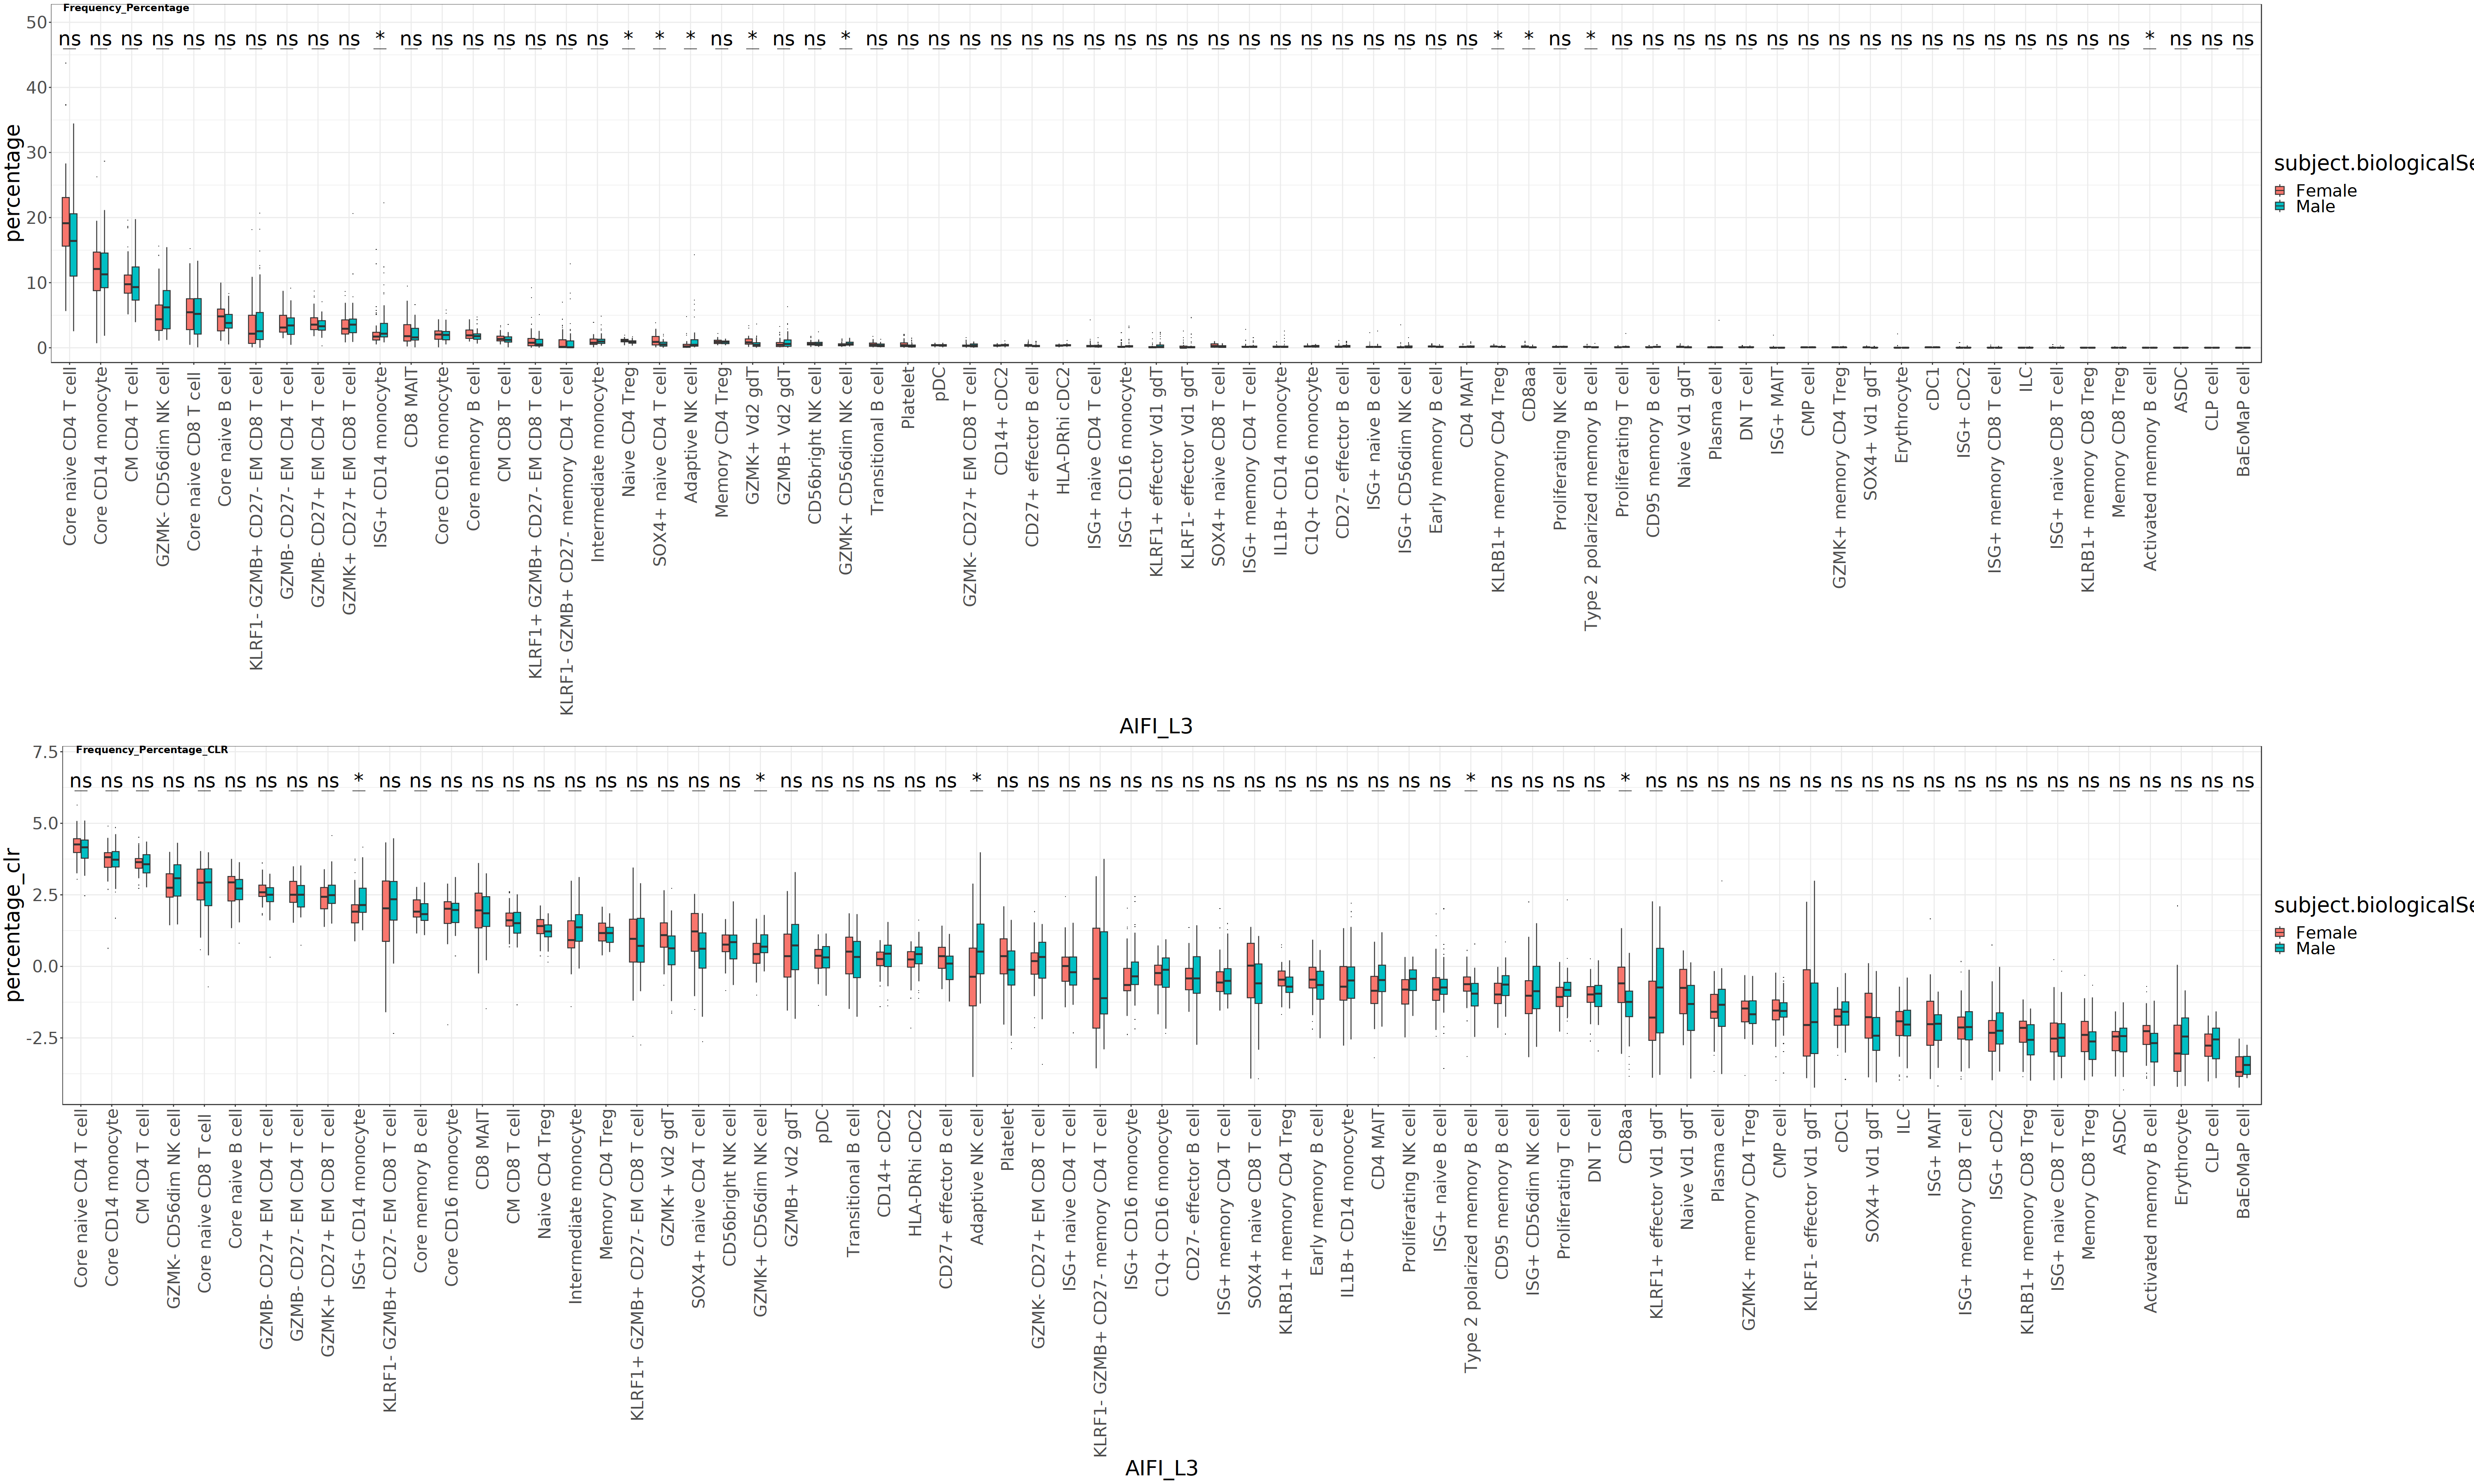

In [39]:
# Percentage comparing Age WITHOUT CMV seperation

#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result %>%
  select(percentage,percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>%
  wilcox_test(percentage_clr~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()
#stat_test

significant_cell_types <- stat_test %>%
  filter(p.adj < 0.05) %>%
  select(AIFI_L3, .y., p.adj, p.adj.signif) %>%
  unique()

print(significant_cell_types)

# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =10  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30),)
     # axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        #axis.text.y = element_text(size = 18, color = "black"),
        #axis.title.x = element_text(size = 18, color = "black"),
        #axis.title.y = element_text(size = 18, color = "black"),
       #legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        #legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)


#Percentage CLR comparing Age WITHOUT CMV seperation
p5 <- ggplot(result, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =10  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30, color = "black"))
     # axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        #axis.text.y = element_text(size = 18, color = "black"),
        #axis.title.x = element_text(size = 18, color = "black"),
        #axis.title.y = element_text(size = 18, color = "black"),
       #legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        #legend.title = element_text(size = 15, color = "black"))


#print(p5)

#Combine Plot
library(cowplot)

options(repr.plot.width = 50, repr.plot.height = 30)
# Combine two plots vertically
combined_plot <- plot_grid(p4, p5, labels = c("Frequency_Percentage", "Frequency_Percentage_CLR"), ncol =1)

combined_plot


# A tibble: 5 × 4
  AIFI_L3.5                      .y.                p.adj p.adj.signif
  <chr>                          <chr>              <dbl> <chr>       
1 Adaptive NK cell               percentage_clr 0.0274    *           
2 CD8aa                          percentage_clr 0.0155    *           
3 GZMK+ CD56dim NK cell          percentage_clr 0.0465    *           
4 ISG IIhi CD14 monocyte         percentage_clr 0.0000762 ****        
5 Type 2 polarized memory B cell percentage_clr 0.0364    *           


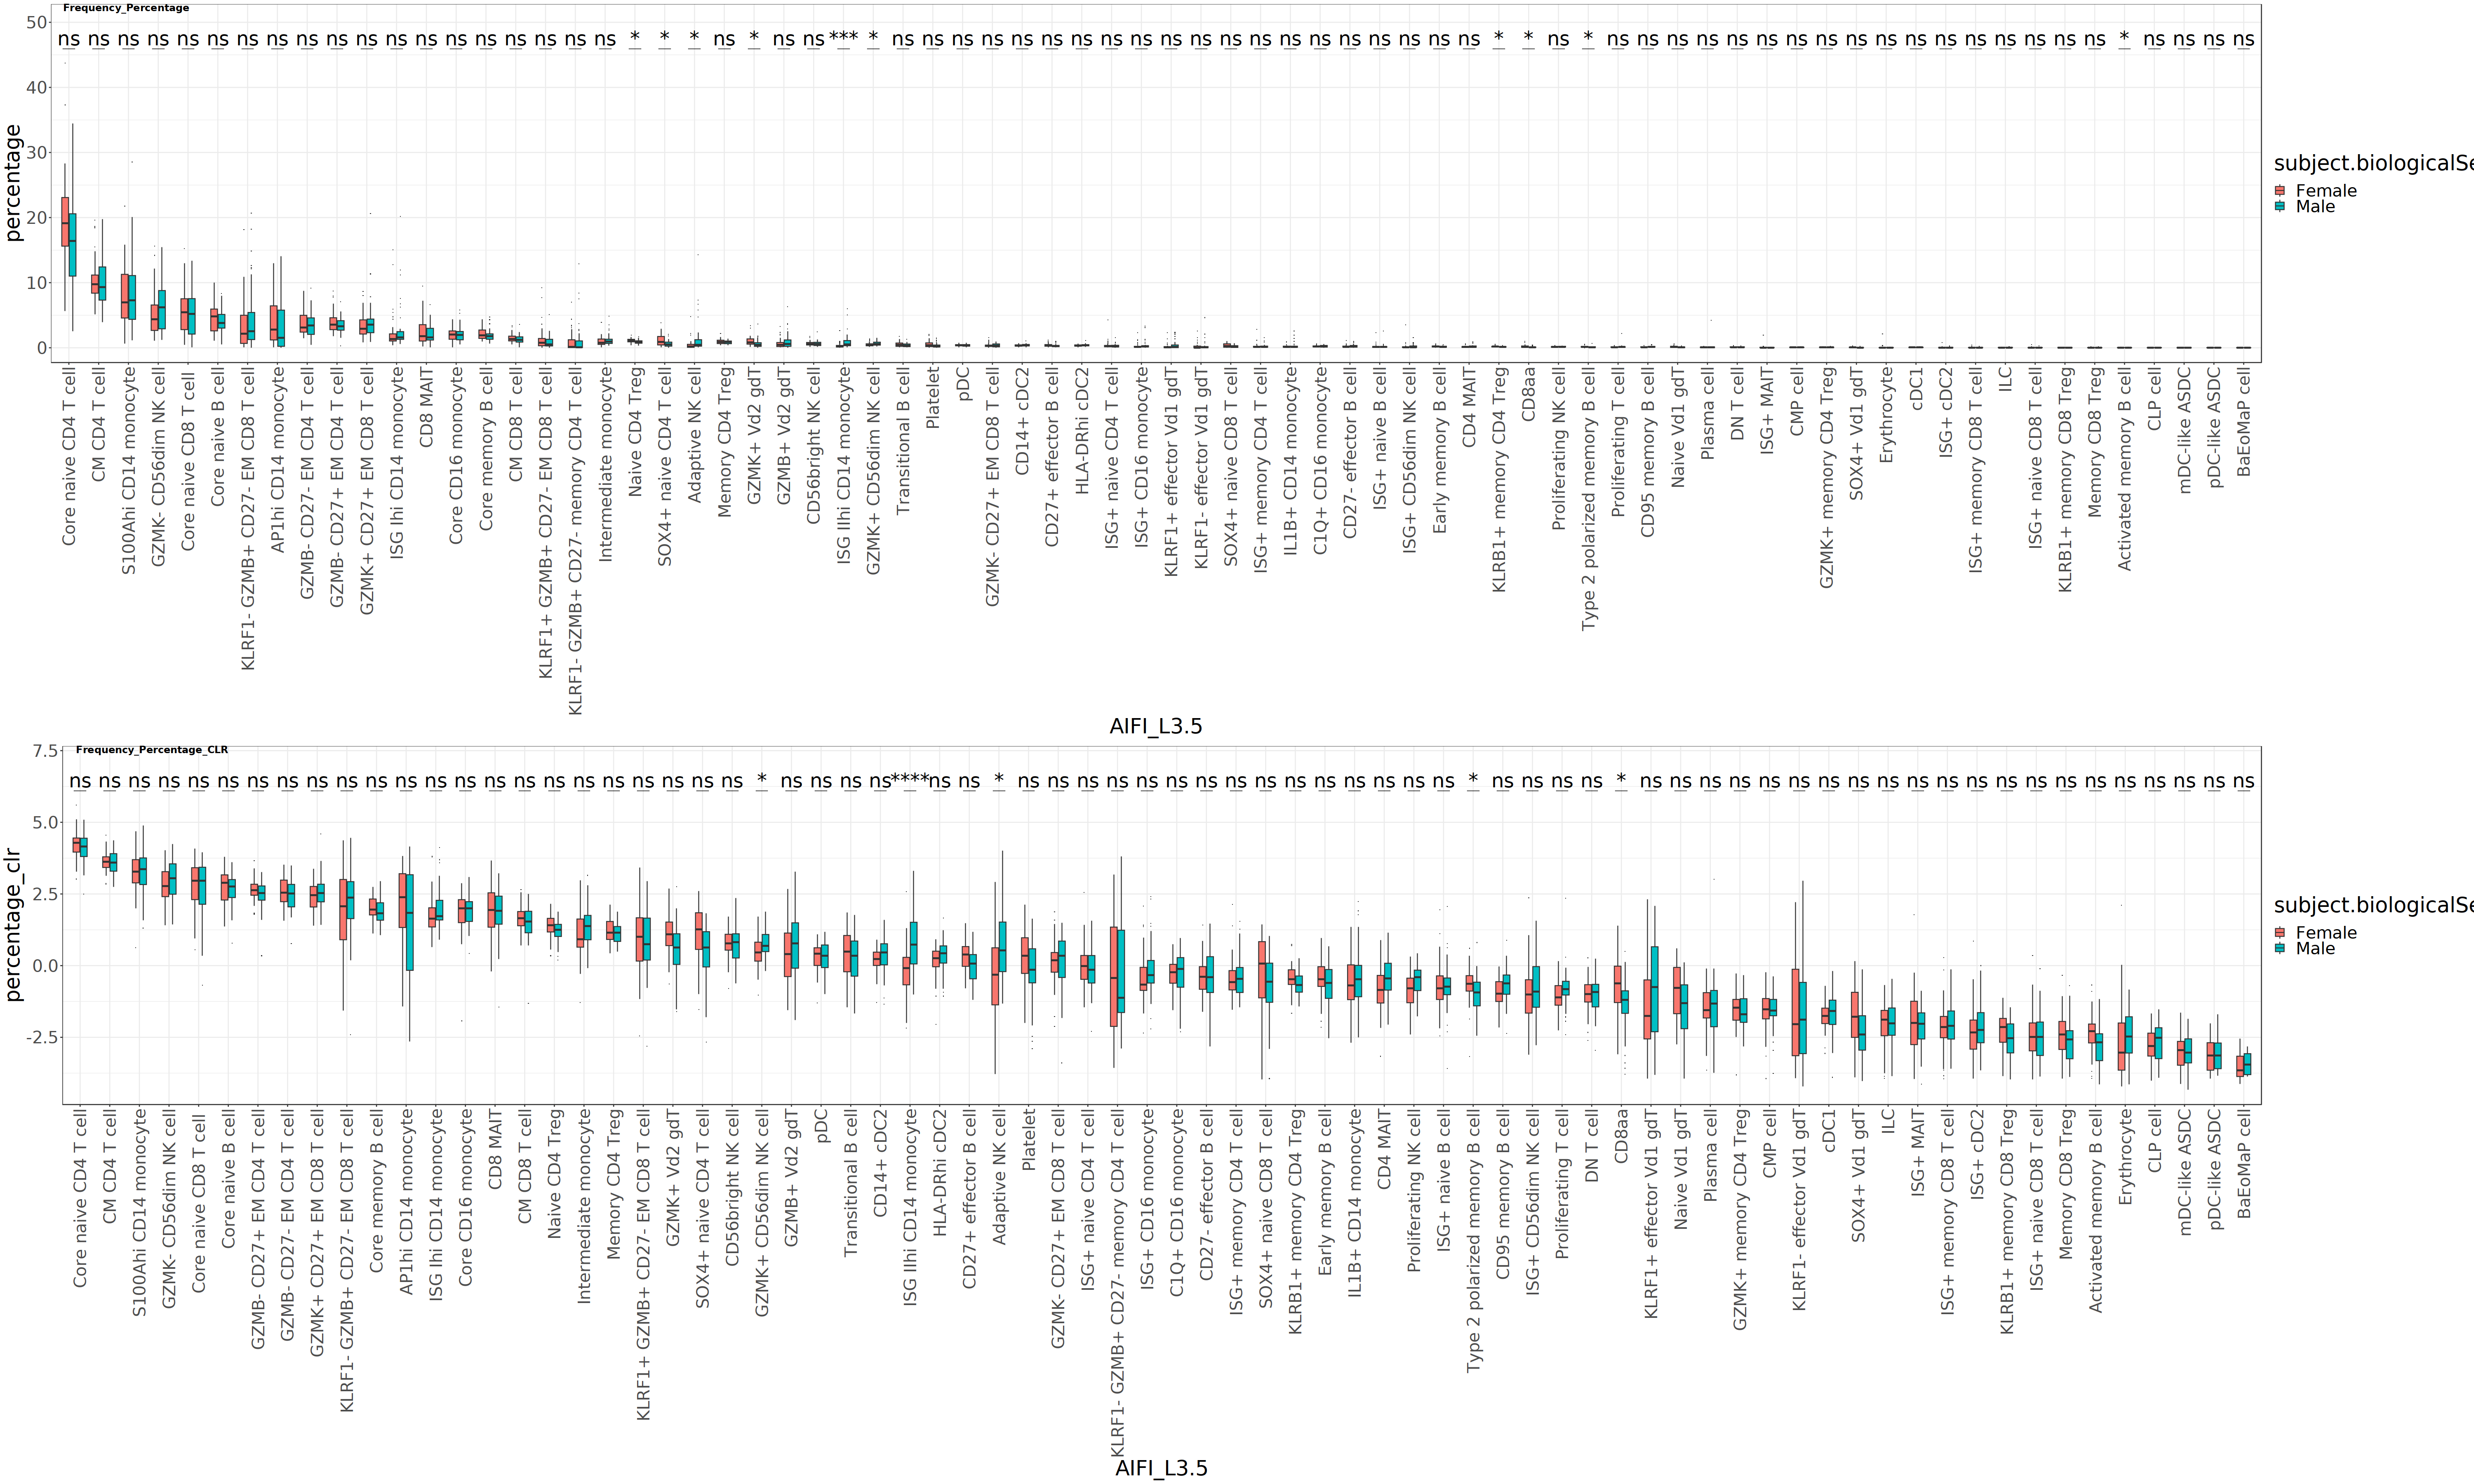

In [42]:
# Percentage comparing Age WITHOUT CMV seperation

#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result %>%
  select(percentage,percentage_clr, AIFI_L3.5, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3.5) %>%
  wilcox_test(percentage_clr~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()
#stat_test

significant_cell_types <- stat_test %>%
  filter(p.adj < 0.05) %>%
  select(AIFI_L3.5, .y., p.adj, p.adj.signif) %>%
  unique()

print(significant_cell_types)

# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result, aes(x = reorder(AIFI_L3.5, desc(percentage)) , y = percentage, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3.5", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =10  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30),)
     # axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        #axis.text.y = element_text(size = 18, color = "black"),
        #axis.title.x = element_text(size = 18, color = "black"),
        #axis.title.y = element_text(size = 18, color = "black"),
       #legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        #legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)


#Percentage CLR comparing Age WITHOUT CMV seperation
p5 <- ggplot(result, aes(x = reorder(AIFI_L3.5, desc(percentage_clr)) , y = percentage_clr, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3.5", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =10  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30, color = "black"))
     # axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        #axis.text.y = element_text(size = 18, color = "black"),
        #axis.title.x = element_text(size = 18, color = "black"),
        #axis.title.y = element_text(size = 18, color = "black"),
       #legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        #legend.title = element_text(size = 15, color = "black"))


#print(p5)

#Combine Plot
library(cowplot)

options(repr.plot.width = 50, repr.plot.height = 30)
# Combine two plots vertically
combined_plot <- plot_grid(p4, p5, labels = c("Frequency_Percentage", "Frequency_Percentage_CLR"), ncol =1)

combined_plot


# A tibble: 16 × 4
   AIFI_L3                              .y.               p.adj p.adj.signif
   <chr>                                <chr>             <dbl> <chr>       
 1 Adaptive NK cell                     percentage_clr 2.07e- 7 ****        
 2 CD4 MAIT                             percentage_clr 4.34e- 2 *           
 3 CD56bright NK cell                   percentage_clr 1.52e- 2 *           
 4 CD8 MAIT                             percentage_clr 4.26e- 3 **          
 5 GZMK+ CD27+ EM CD8 T cell            percentage_clr 4.34e- 2 *           
 6 GZMK+ CD56dim NK cell                percentage_clr 3.40e- 3 **          
 7 GZMK- CD27+ EM CD8 T cell            percentage_clr 2.25e- 4 ***         
 8 GZMK- CD56dim NK cell                percentage_clr 3.48e- 4 ***         
 9 ISG+ CD56dim NK cell                 percentage_clr 4.14e- 2 *           
10 KLRF1+ GZMB+ CD27- EM CD8 T cell     percentage_clr 7.85e- 4 ***         
11 KLRF1+ effector Vd1 gdT              percentage_clr 1.

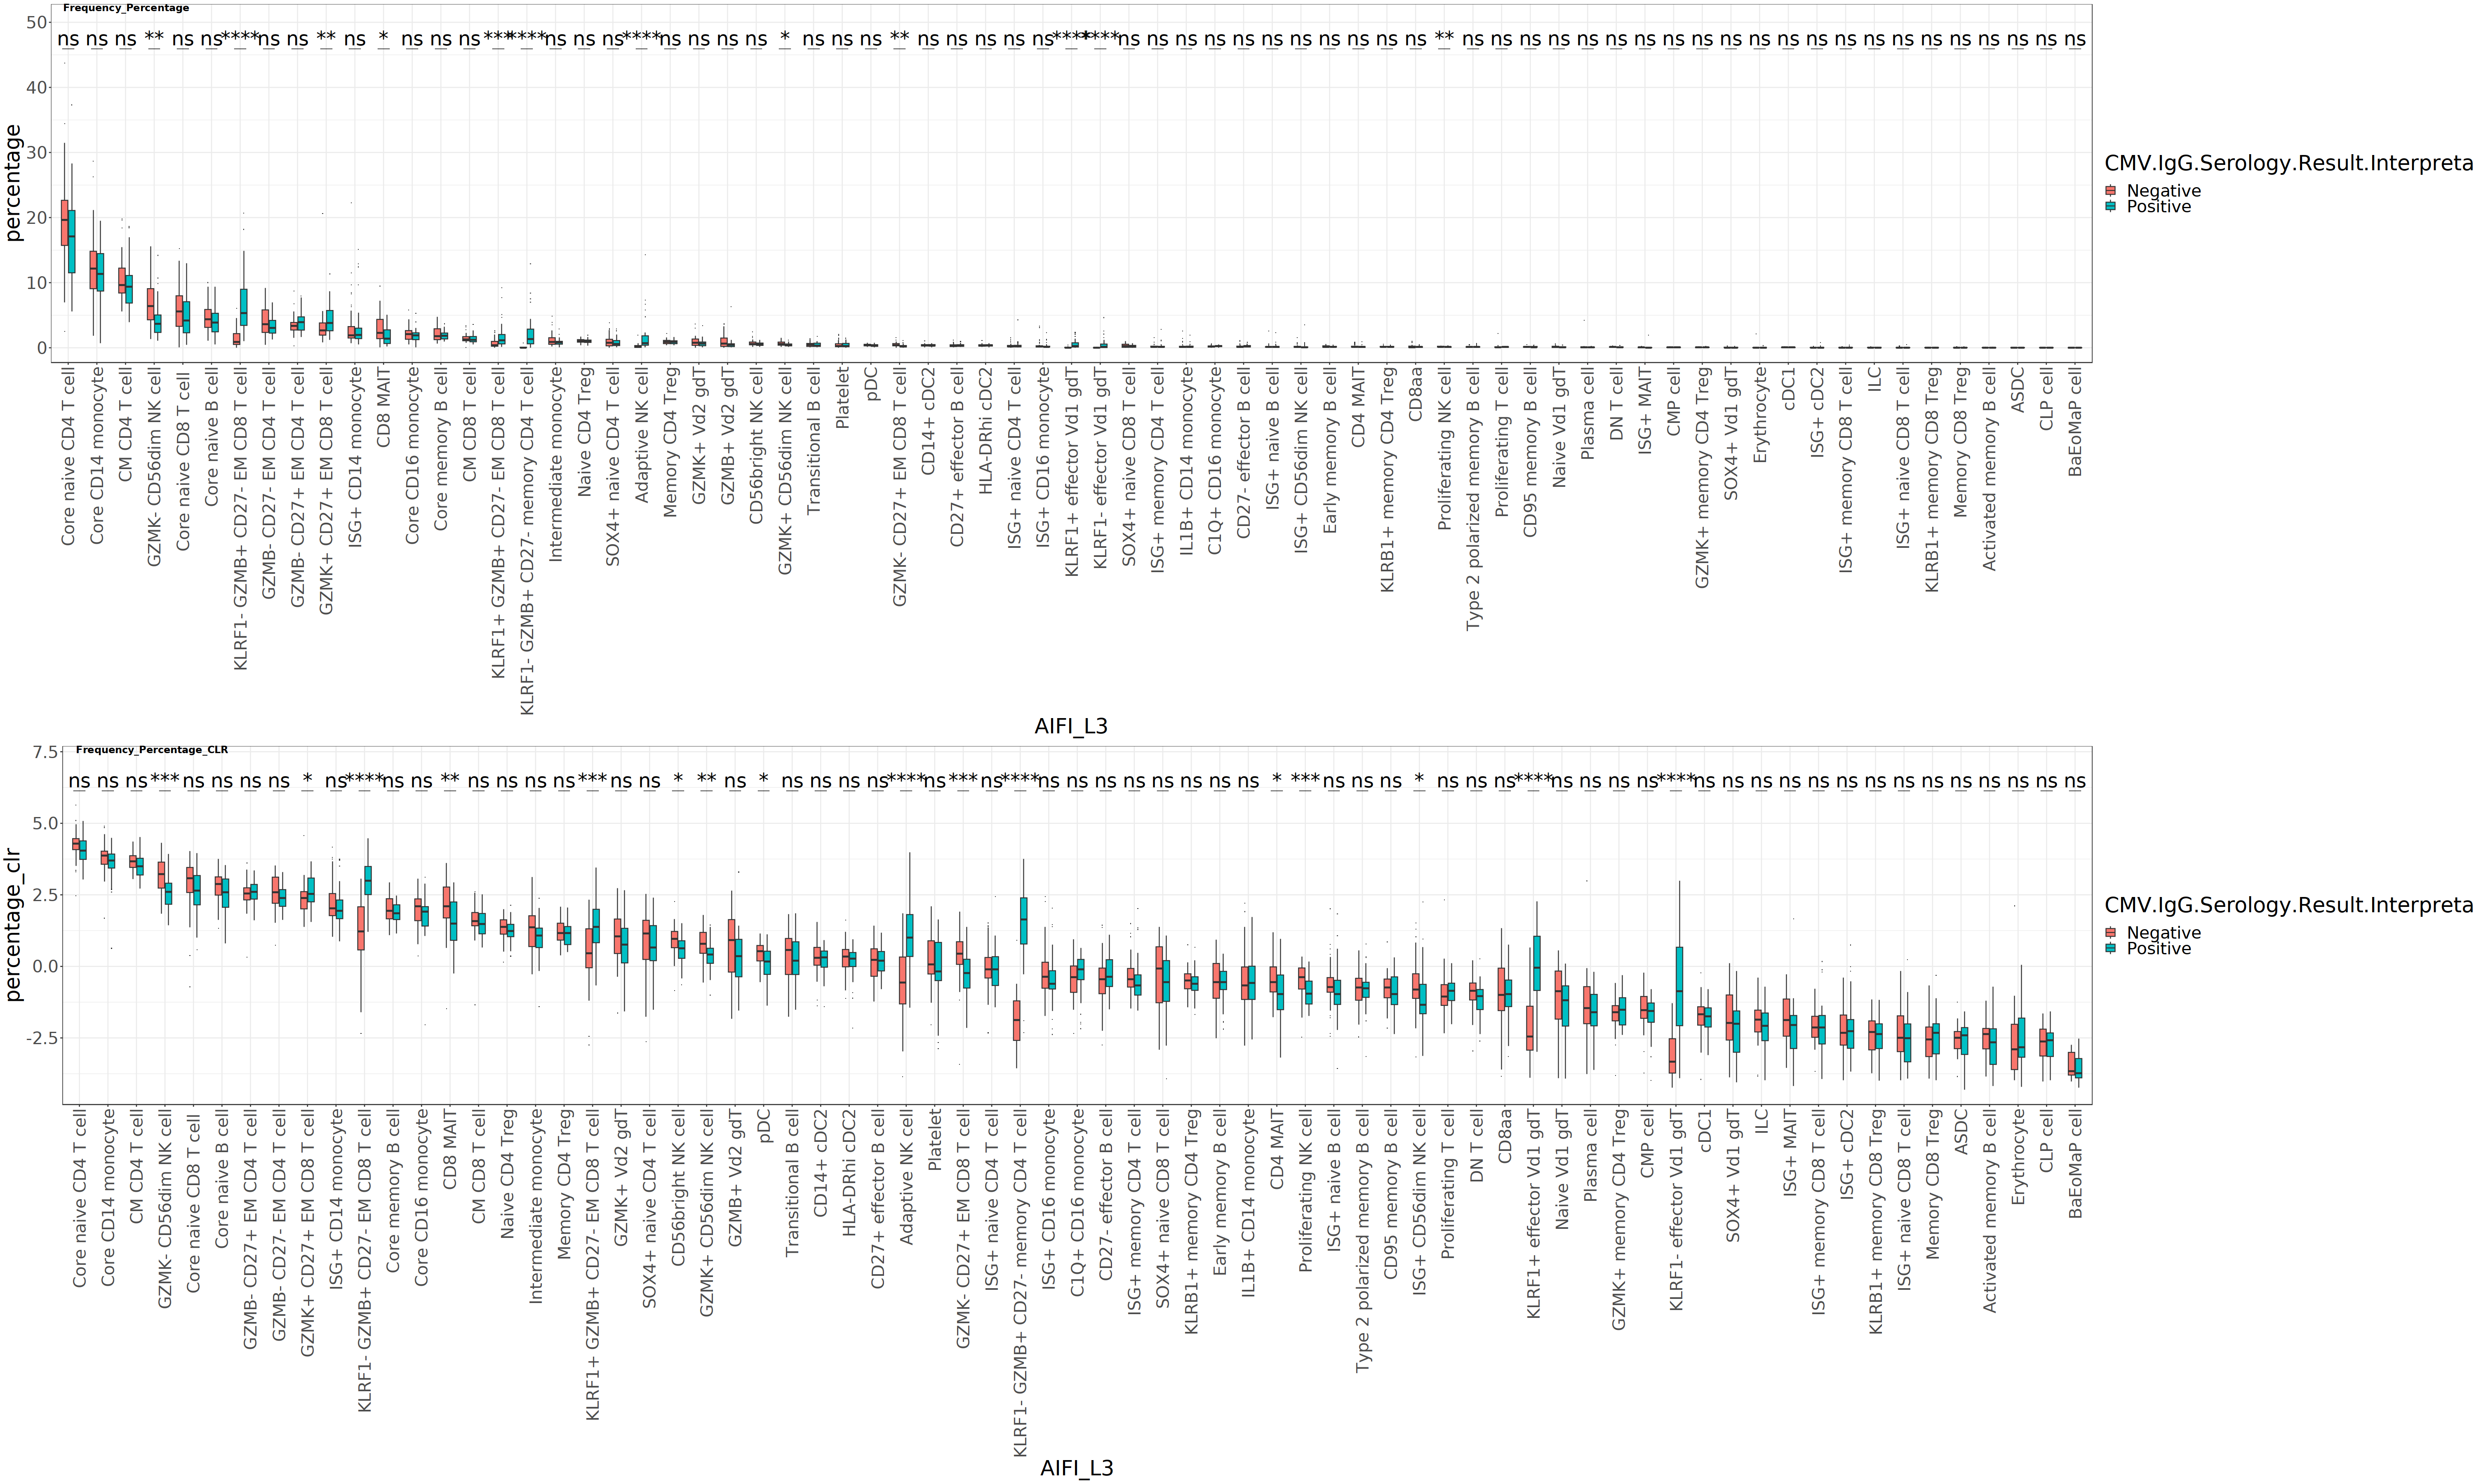

In [16]:
# Percentage comparing Age WITHOUT CMV seperation

#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result %>%
  select(percentage,percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>%
  wilcox_test(percentage_clr ~ CMV.IgG.Serology.Result.Interpretation) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()
#stat_test

significant_cell_types <- stat_test %>%
  filter(p.adj < 0.05) %>%
  select(AIFI_L3, .y., p.adj, p.adj.signif) %>%
  unique()

print(significant_cell_types)

# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, fill = CMV.IgG.Serology.Result.Interpretation)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = CMV.IgG.Serology.Result.Interpretation),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =10  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30),)
     # axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        #axis.text.y = element_text(size = 18, color = "black"),
        #axis.title.x = element_text(size = 18, color = "black"),
        #axis.title.y = element_text(size = 18, color = "black"),
       #legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        #legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)


#Percentage CLR comparing Age WITHOUT CMV seperation
p5 <- ggplot(result, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, fill = CMV.IgG.Serology.Result.Interpretation)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = CMV.IgG.Serology.Result.Interpretation),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =10  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30, color = "black"))
     # axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        #axis.text.y = element_text(size = 18, color = "black"),
        #axis.title.x = element_text(size = 18, color = "black"),
        #axis.title.y = element_text(size = 18, color = "black"),
       #legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        #legend.title = element_text(size = 15, color = "black"))


#print(p5)

#Combine Plot
library(cowplot)

options(repr.plot.width = 50, repr.plot.height = 30)
# Combine two plots vertically
combined_plot <- plot_grid(p4, p5, labels = c("Frequency_Percentage", "Frequency_Percentage_CLR"), ncol =1)

combined_plot


# Sex seperated by CMV


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


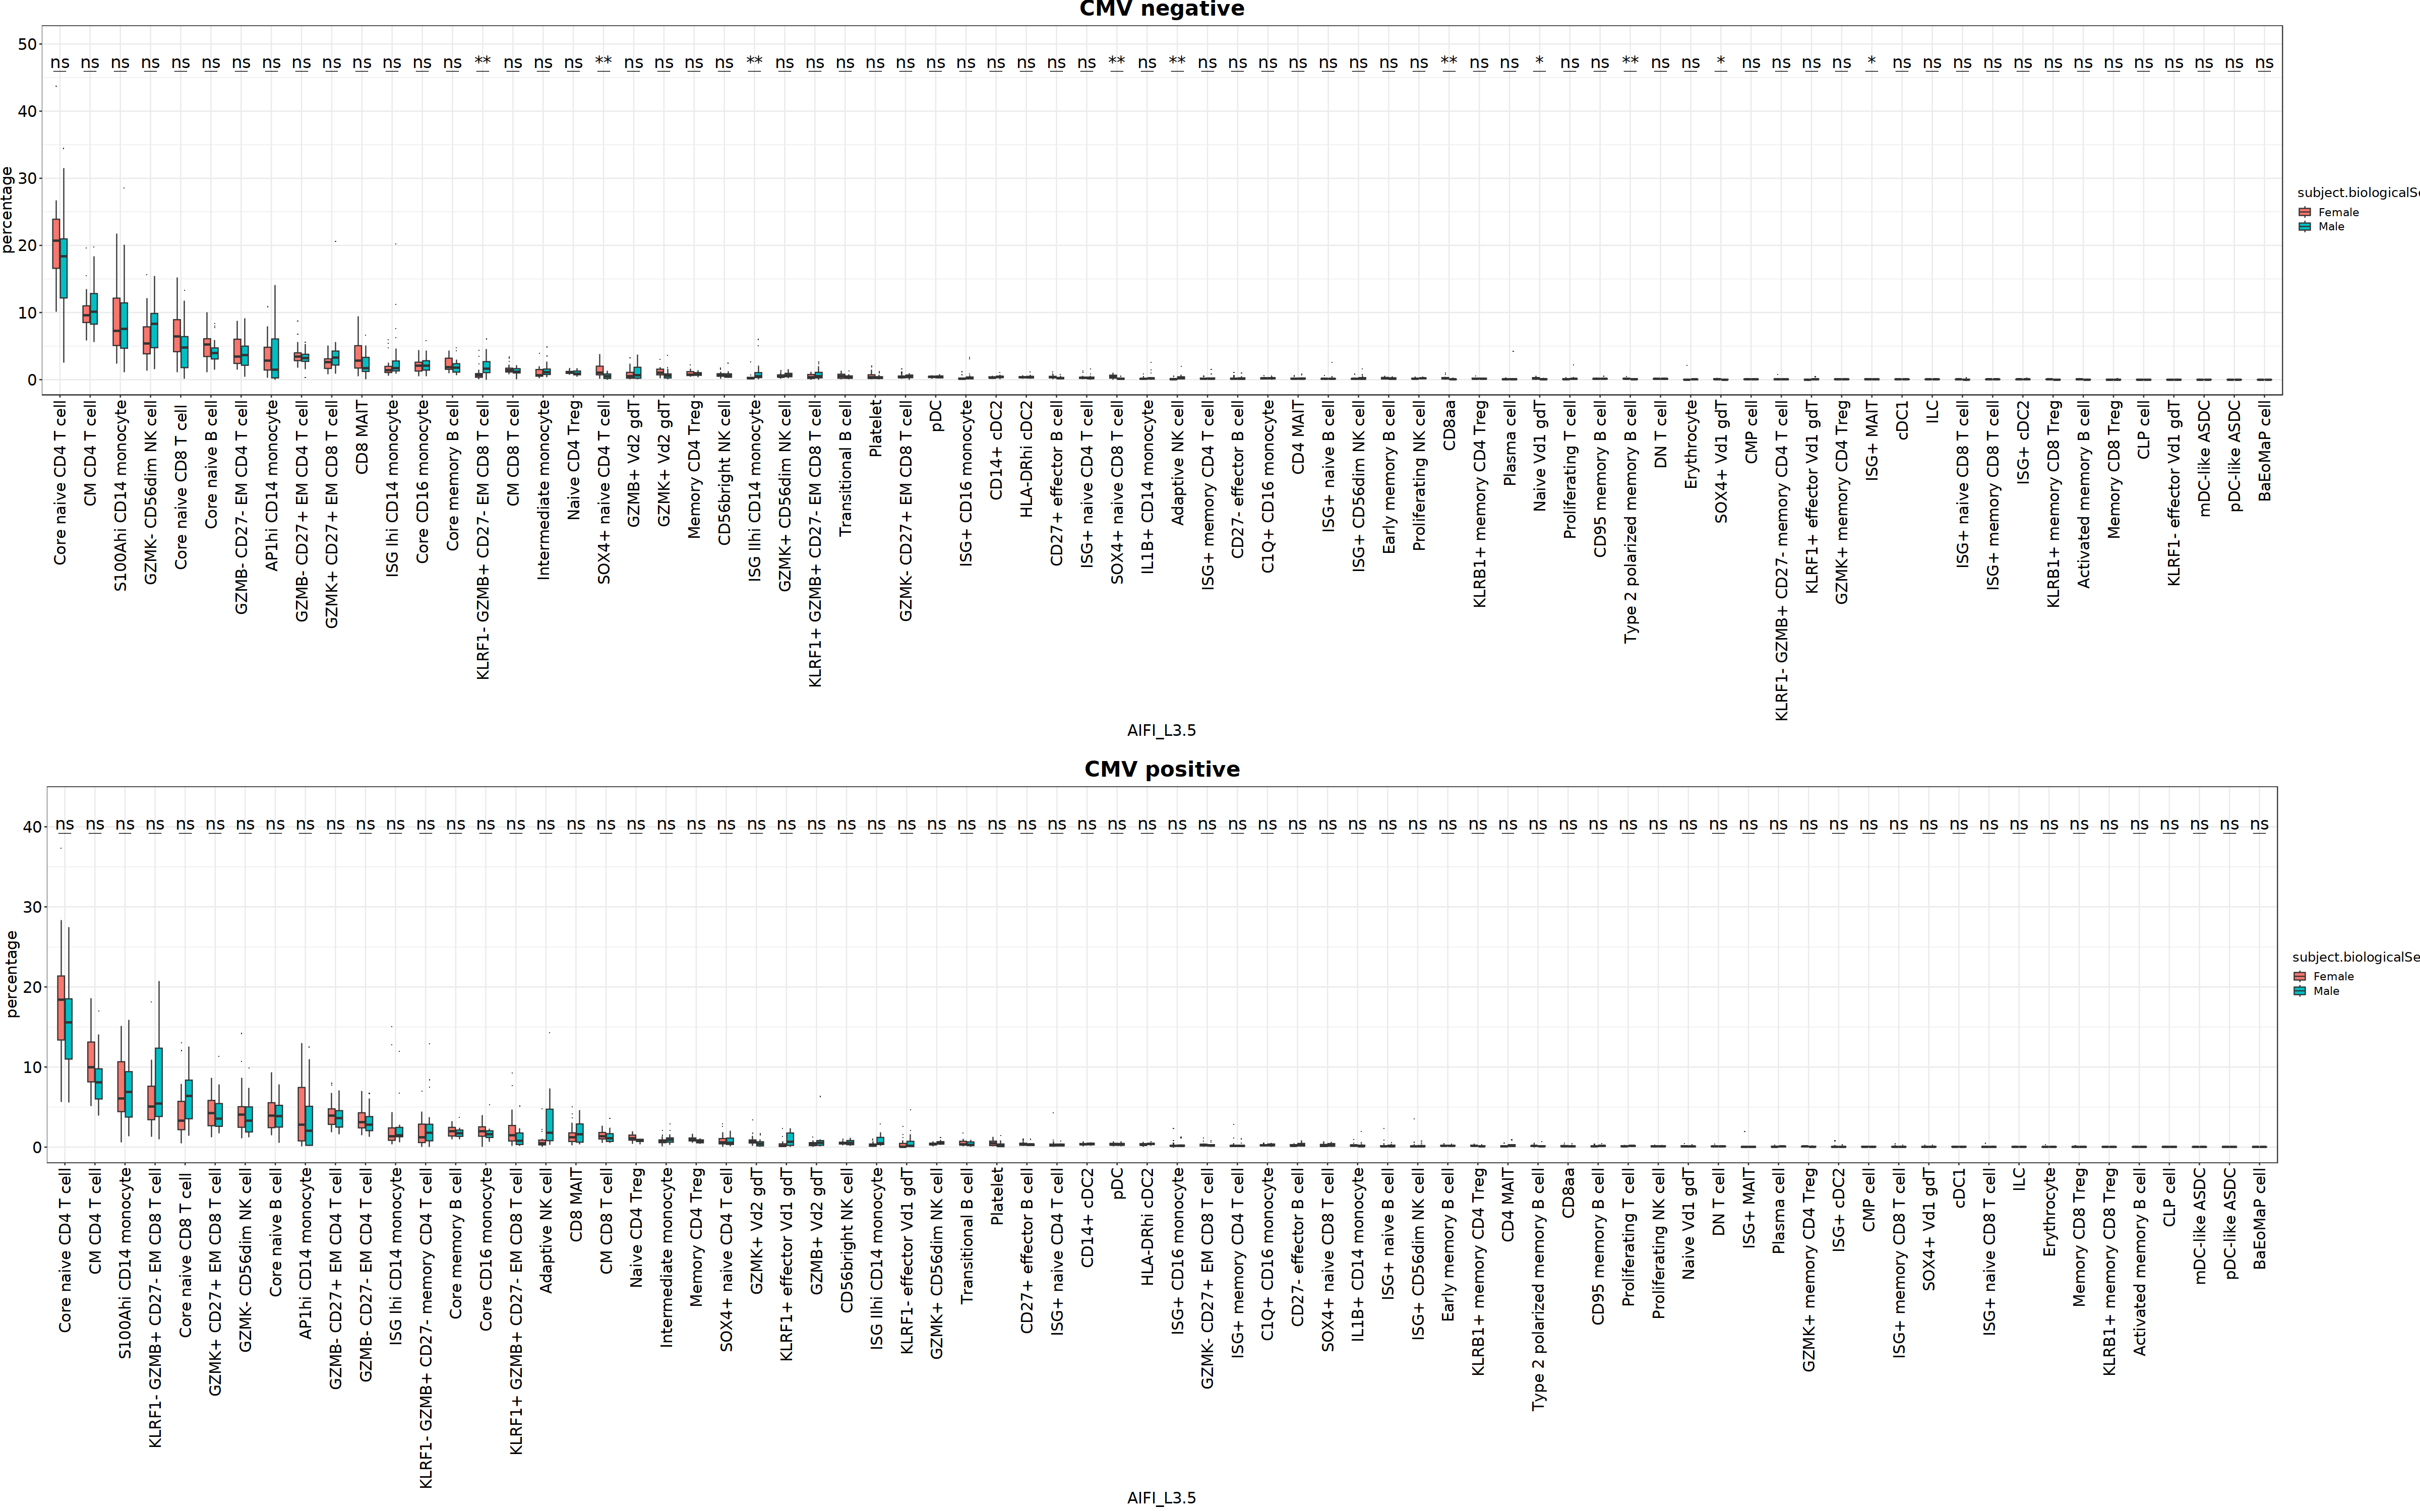

In [53]:
# Percentage comparing Sex across CMV

####################. Negative CMV ####################
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black")) +
   ggtitle("CMV negative") + theme(plot.title = element_text(size = 25, hjust = 0.5, face = "bold"))

# Display the plot
#print(p1)


####################. Positive CMV ####################
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))+
  ggtitle("CMV positive") + theme(plot.title = element_text(size = 25, hjust = 0.5, face = "bold"))

# Display the plot
#print(p2)

library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
#combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1, label_size = 20, vjust = 0)
#combined_plot <- plot_grid(p1, p2, ncol=1,  nrow = 2, rel_heights = c(1, 2))

stacked_plots <- plot_grid(p1 + theme(plot.margin = margin(b = 20)), p2, nrow = 2, rel_heights = c(1, 1))

# Print the stacked plots
stacked_plots


#combined_plot



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


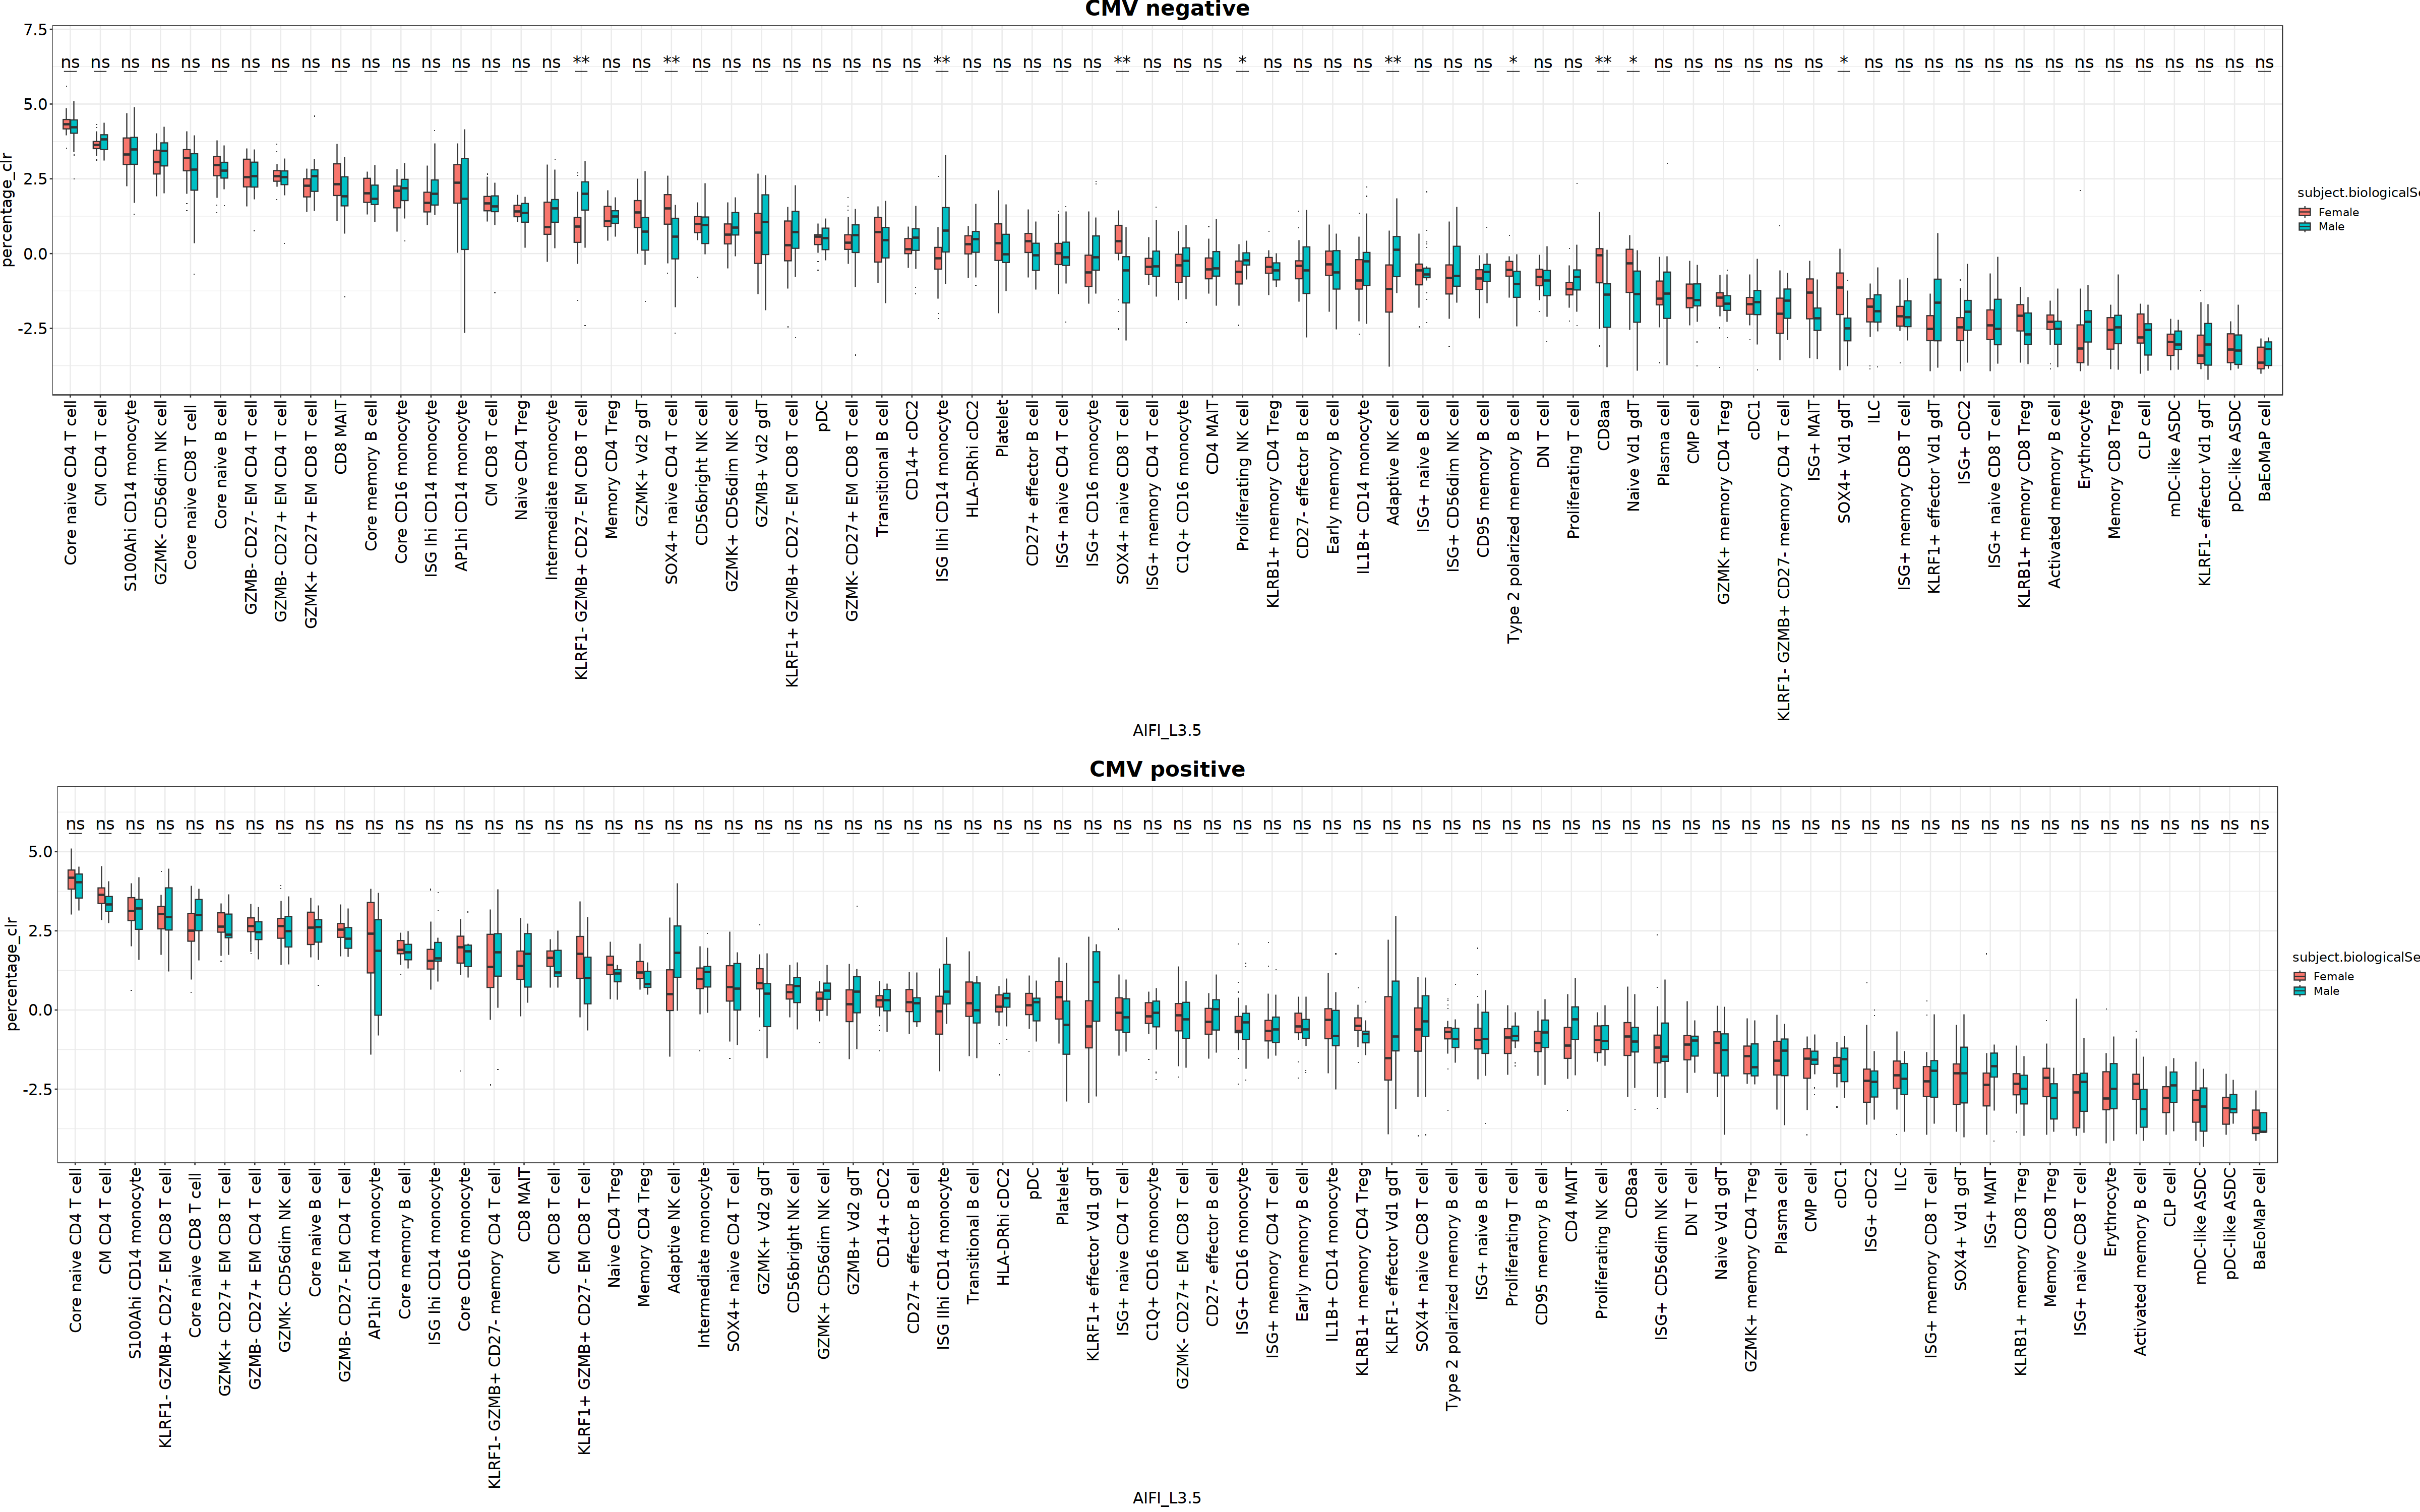

In [54]:
# CLR comparing Sex across CMV

####################. Negative CMV ####################
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Negative', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage,percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30, color = "black"),
      axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black")) +
   ggtitle("CMV negative") + theme(plot.title = element_text(size = 25, hjust = 0.5, ,  face = "bold"))

# Display the plot
#print(p1)


####################. Positive CMV ####################
result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3, CMV.IgG.Serology.Result.Interpretation) %>%
  wilcox_test(percentage_clr ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30, color = "black"),
      axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))+
  ggtitle("CMV positive") + theme(plot.title = element_text(size = 25, hjust = 0.5, ,  face = "bold"))

# Display the plot
#print(p2)

library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
#combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1, label_size = 20, vjust = 0)
#combined_plot <- plot_grid(p1, p2, ncol=1,  nrow = 2, rel_heights = c(1, 2))

stacked_plots <- plot_grid(p1 + theme(plot.margin = margin(b = 20)), p2, nrow = 2, rel_heights = c(1, 1))

# Print the stacked plots
stacked_plots


#combined_plot



# Sex seperated by BRI

In [43]:
result

AIFI_L3 subject.subjectGuid count percentage  percentage_clr
1    ASDC    BR1001               6    0.032367697 -2.232976     
2    ASDC    BR1002               5    0.026374090 -2.242500     
3    ASDC    BR1003               4    0.020946795 -2.763896     
4    ASDC    BR1004               3    0.017105713 -2.626914     
5    ASDC    BR1005               5    0.028096201 -1.943233     
6    ASDC    BR1006               4    0.023009664 -2.337902     
7    ASDC    BR1007               4    0.023160211 -2.602391     
8    ASDC    BR1008               4    0.025100402 -2.091868     
9    ASDC    BR1009               4    0.022412730 -2.536634     
10   ASDC    BR1011               3    0.018649758 -2.715862     
11   ASDC    BR1012               1    0.006553509 -3.566857     
12   ASDC    BR1013               2    0.009507963 -3.201433     
13   ASDC    BR1014               4    0.021507689 -2.850748     
14   ASDC    BR1015               4    0.026546323 -2.176817     
15   ASDC    BR1016               3    0.019932230 -2.340578     
16   ASDC    BR1017               4    0.025056377 -2.439159     
17   ASDC    BR1018               5    0.030627871 -1.986608     
18   ASDC    BR1019               2    0.010223903 -3.247932     
19   ASDC    BR1021               2    0.015294028 -2.978201     
20   ASDC    BR1023               2    0.013191742 -3.143396     
21   ASDC    BR1024               4    0.023729015 -2.487136     
22   ASDC    BR1025              11    0.065931431 -1.574998     
23   ASDC    BR1026               1    0.005161823 -3.843834     
24   ASDC    BR1030               2    0.010256936 -3.102922     
25   ASDC    BR1031               6    0.038158229 -1.874726     
26   ASDC    BR1032               4    0.023959269 -2.407843     
27   ASDC    BR1033               4    0.023230153 -2.439822     
28   ASDC    BR1037              11    0.061473119 -1.587410     
29   ASDC    BR1040               1    0.006266842 -3.846834     
30   ASDC    BR1041               4    0.022824536 -2.822382     
⋮    ⋮       ⋮                   ⋮     ⋮           ⋮             
6288 pDC     BR2022               48   0.2587043    0.11571486   
6289 pDC     BR2023               40   0.2463813   -0.21193240   
6290 pDC     BR2024               65   0.3518078    0.41850681   
6291 pDC     BR2025               59   0.2401693   -0.16014478   
6292 pDC     BR2026               43   0.2261373    0.09178934   
6293 pDC     BR2028               98   0.4713578    0.74281399   
6294 pDC     BR2029               29   0.2289594   -0.34374520   
6295 pDC     BR2030               78   0.3422253    0.30908005   
6296 pDC     BR2031               65   0.4007151    0.55451717   
6297 pDC     BR2032               63   0.4446640    0.53769616   
6298 pDC     BR2033               26   0.2029347   -0.38999685   
6299 pDC     BR2034              115   0.6851764    0.87464429   
6300 pDC     BR2035               52   0.5068226    0.54883982   
6301 pDC     BR2036               70   0.4751561    0.56299645   
6302 pDC     BR2037               73   0.4167380    0.36694332   
6303 pDC     BR2038              105   0.6583072    0.94814761   
6304 pDC     BR2039              121   0.6666299    0.96092398   
6305 pDC     BR2040               20   0.1494992   -0.54257886   
6306 pDC     BR2041               37   0.1969028   -0.18738682   
6307 pDC     BR2042               72   0.4232555    0.60560415   
6308 pDC     BR2043               31   0.1917130   -0.31039833   
6309 pDC     BR2044               68   0.3852910    0.33891336   
6310 pDC     BR2045               36   0.2571612   -0.09155611   
6311 pDC     BR2046               52   0.3640692    0.53043494   
6312 pDC     BR2047               60   0.3287491    0.20381570   
6313 pDC     BR2048               52   0.1984809   -0.35912913   
6314 pDC     BR2050               50   0.2750275    0.26528483   
6315 pDC     BR2051               87   0.4701686    0.55636323   
6316 pDC     BR2052               78   0.4772

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


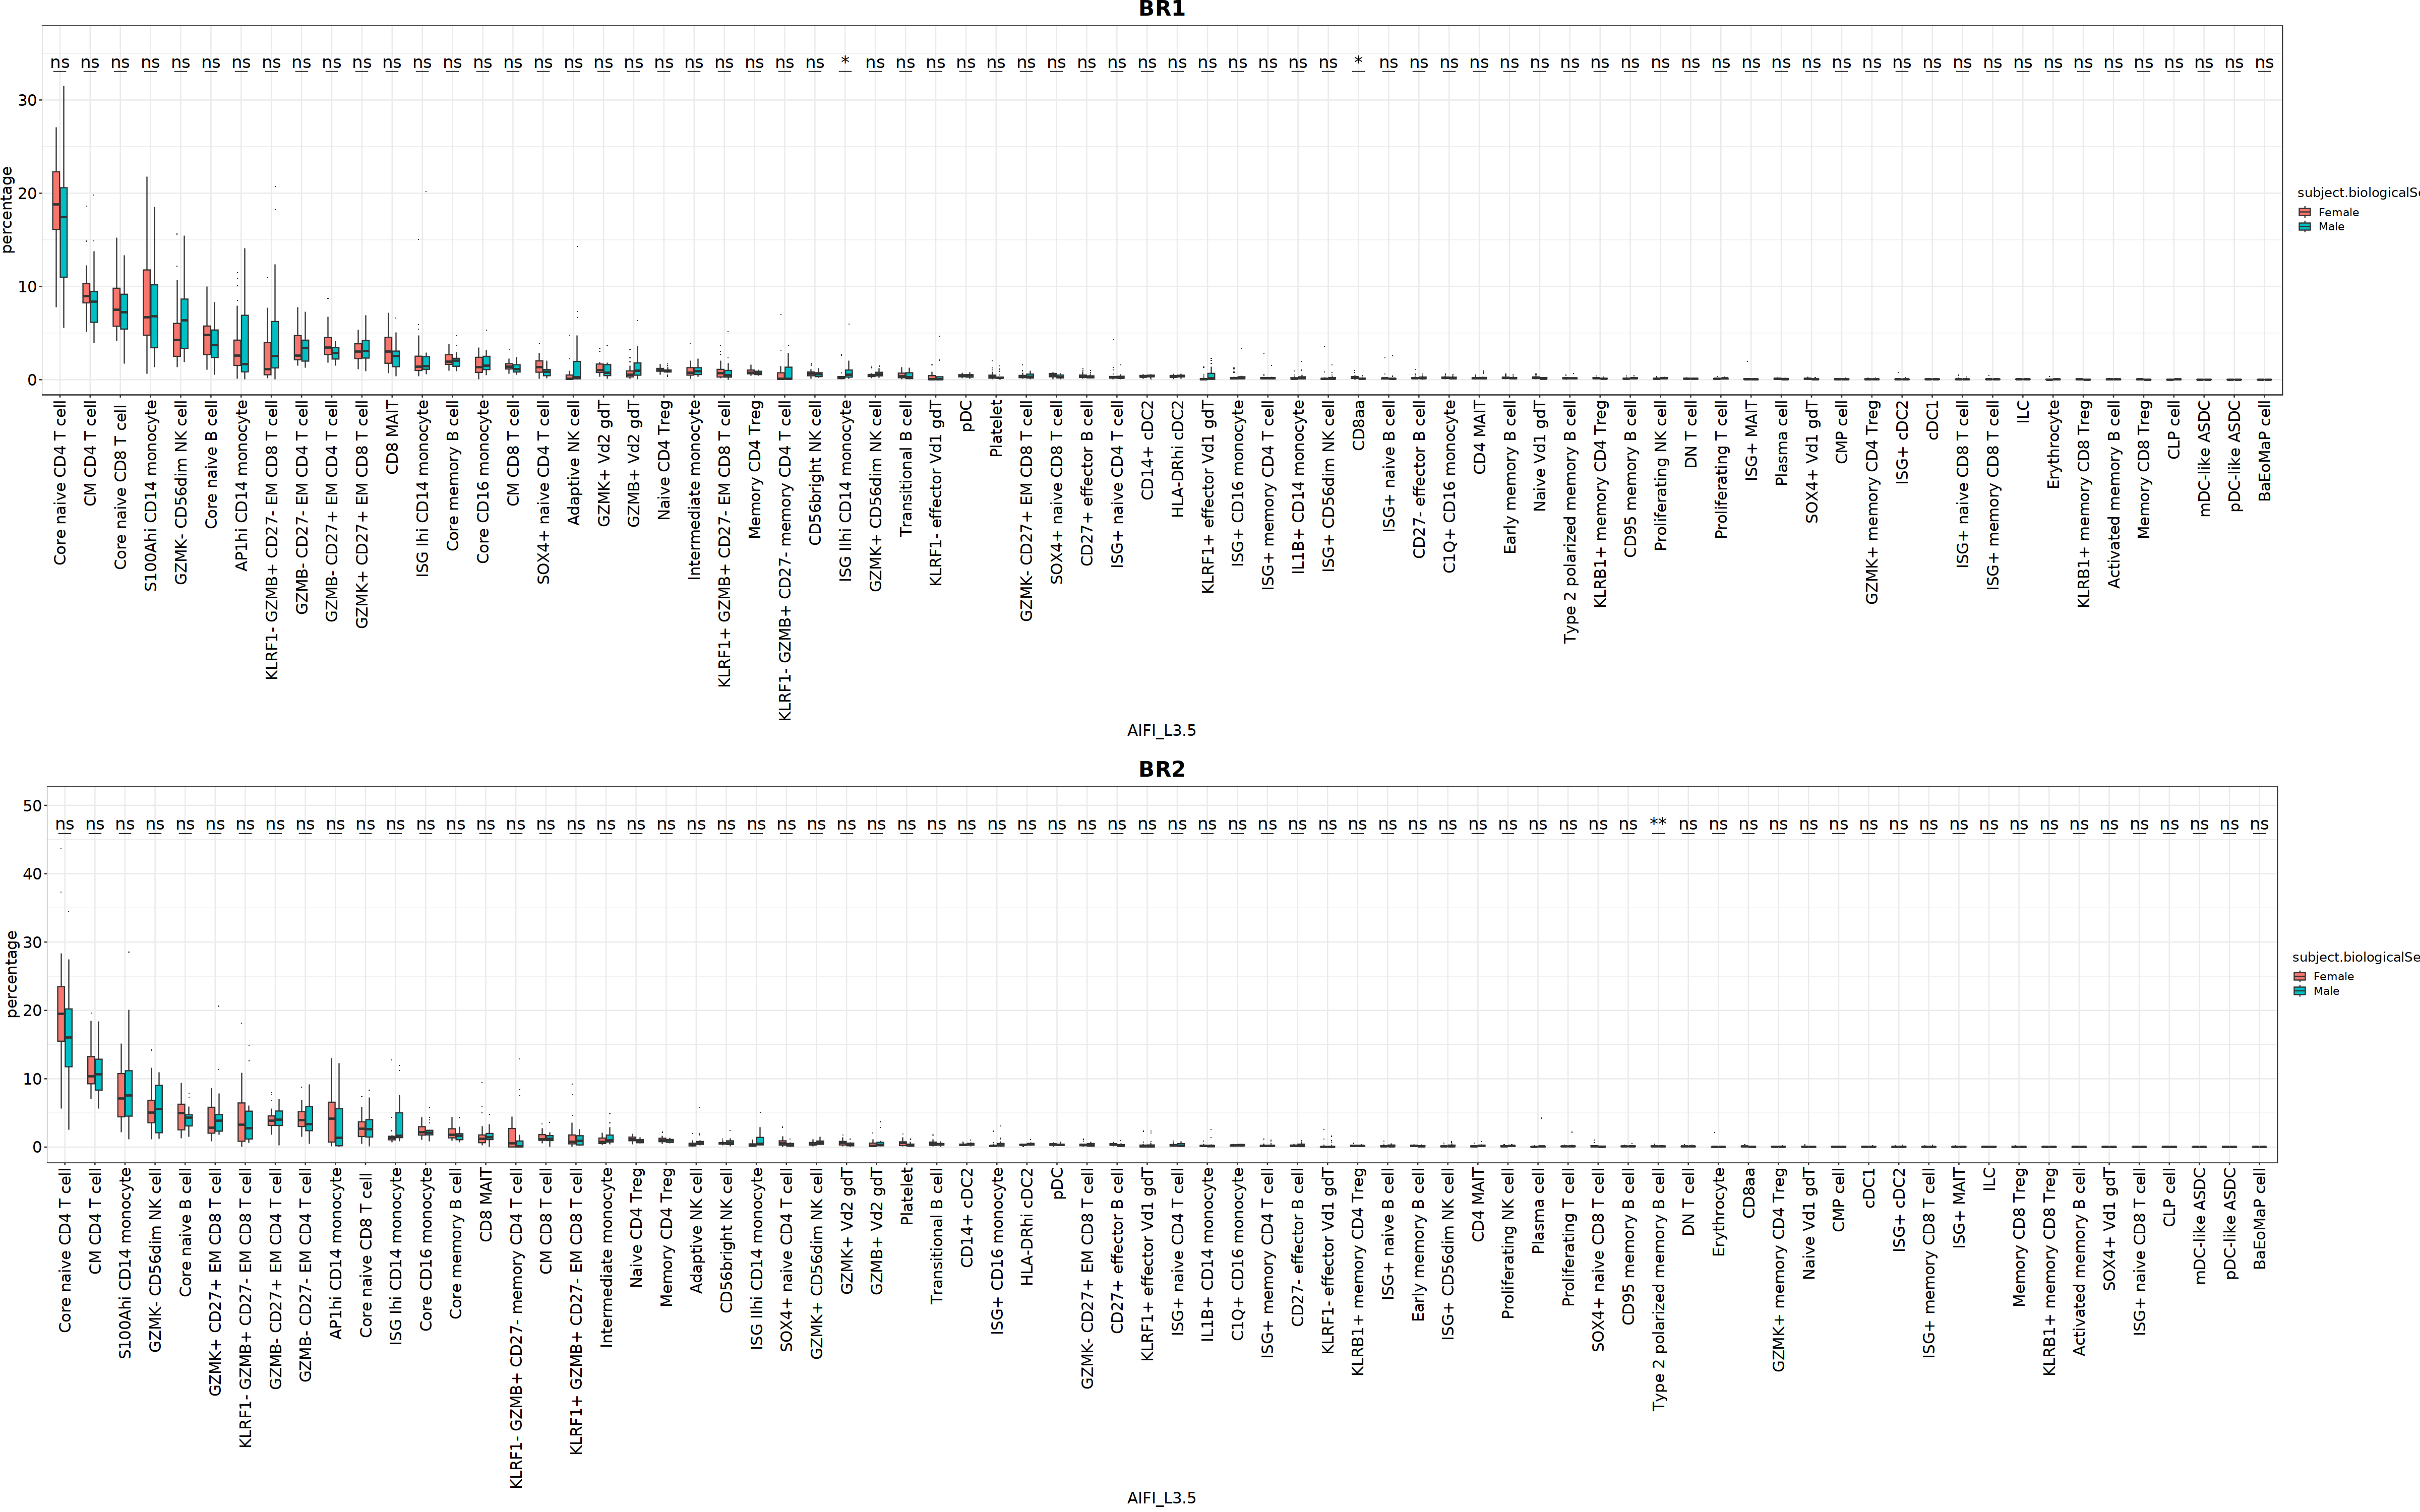

In [55]:
# Percentage comparing Sex across BRI

####################. BR1 ####################
result_cohort <- result[result$cohort.cohortGuid == 'BR1', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3, cohort.cohortGuid) %>%
  wilcox_test(percentage ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black")) +
   ggtitle("BR1") + theme(plot.title = element_text(size = 25, hjust = 0.5, face = "bold"))

# Display the plot
#print(p1)


####################.BR2 ####################
result_cohort <- result[result$cohort.cohortGuid == 'BR2', ]

stat_test<- result_cohort %>%
  select(percentage, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3, cohort.cohortGuid) %>%
  wilcox_test(percentage ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))+
  ggtitle("BR2") + theme(plot.title = element_text(size = 25, hjust = 0.5, face = "bold"))

# Display the plot
#print(p2)

library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
#combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1, label_size = 20, vjust = 0)
#combined_plot <- plot_grid(p1, p2, ncol=1,  nrow = 2, rel_heights = c(1, 2))

stacked_plots <- plot_grid(p1 + theme(plot.margin = margin(b = 20)), p2, nrow = 2, rel_heights = c(1, 1))

# Print the stacked plots
stacked_plots


#combined_plot



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


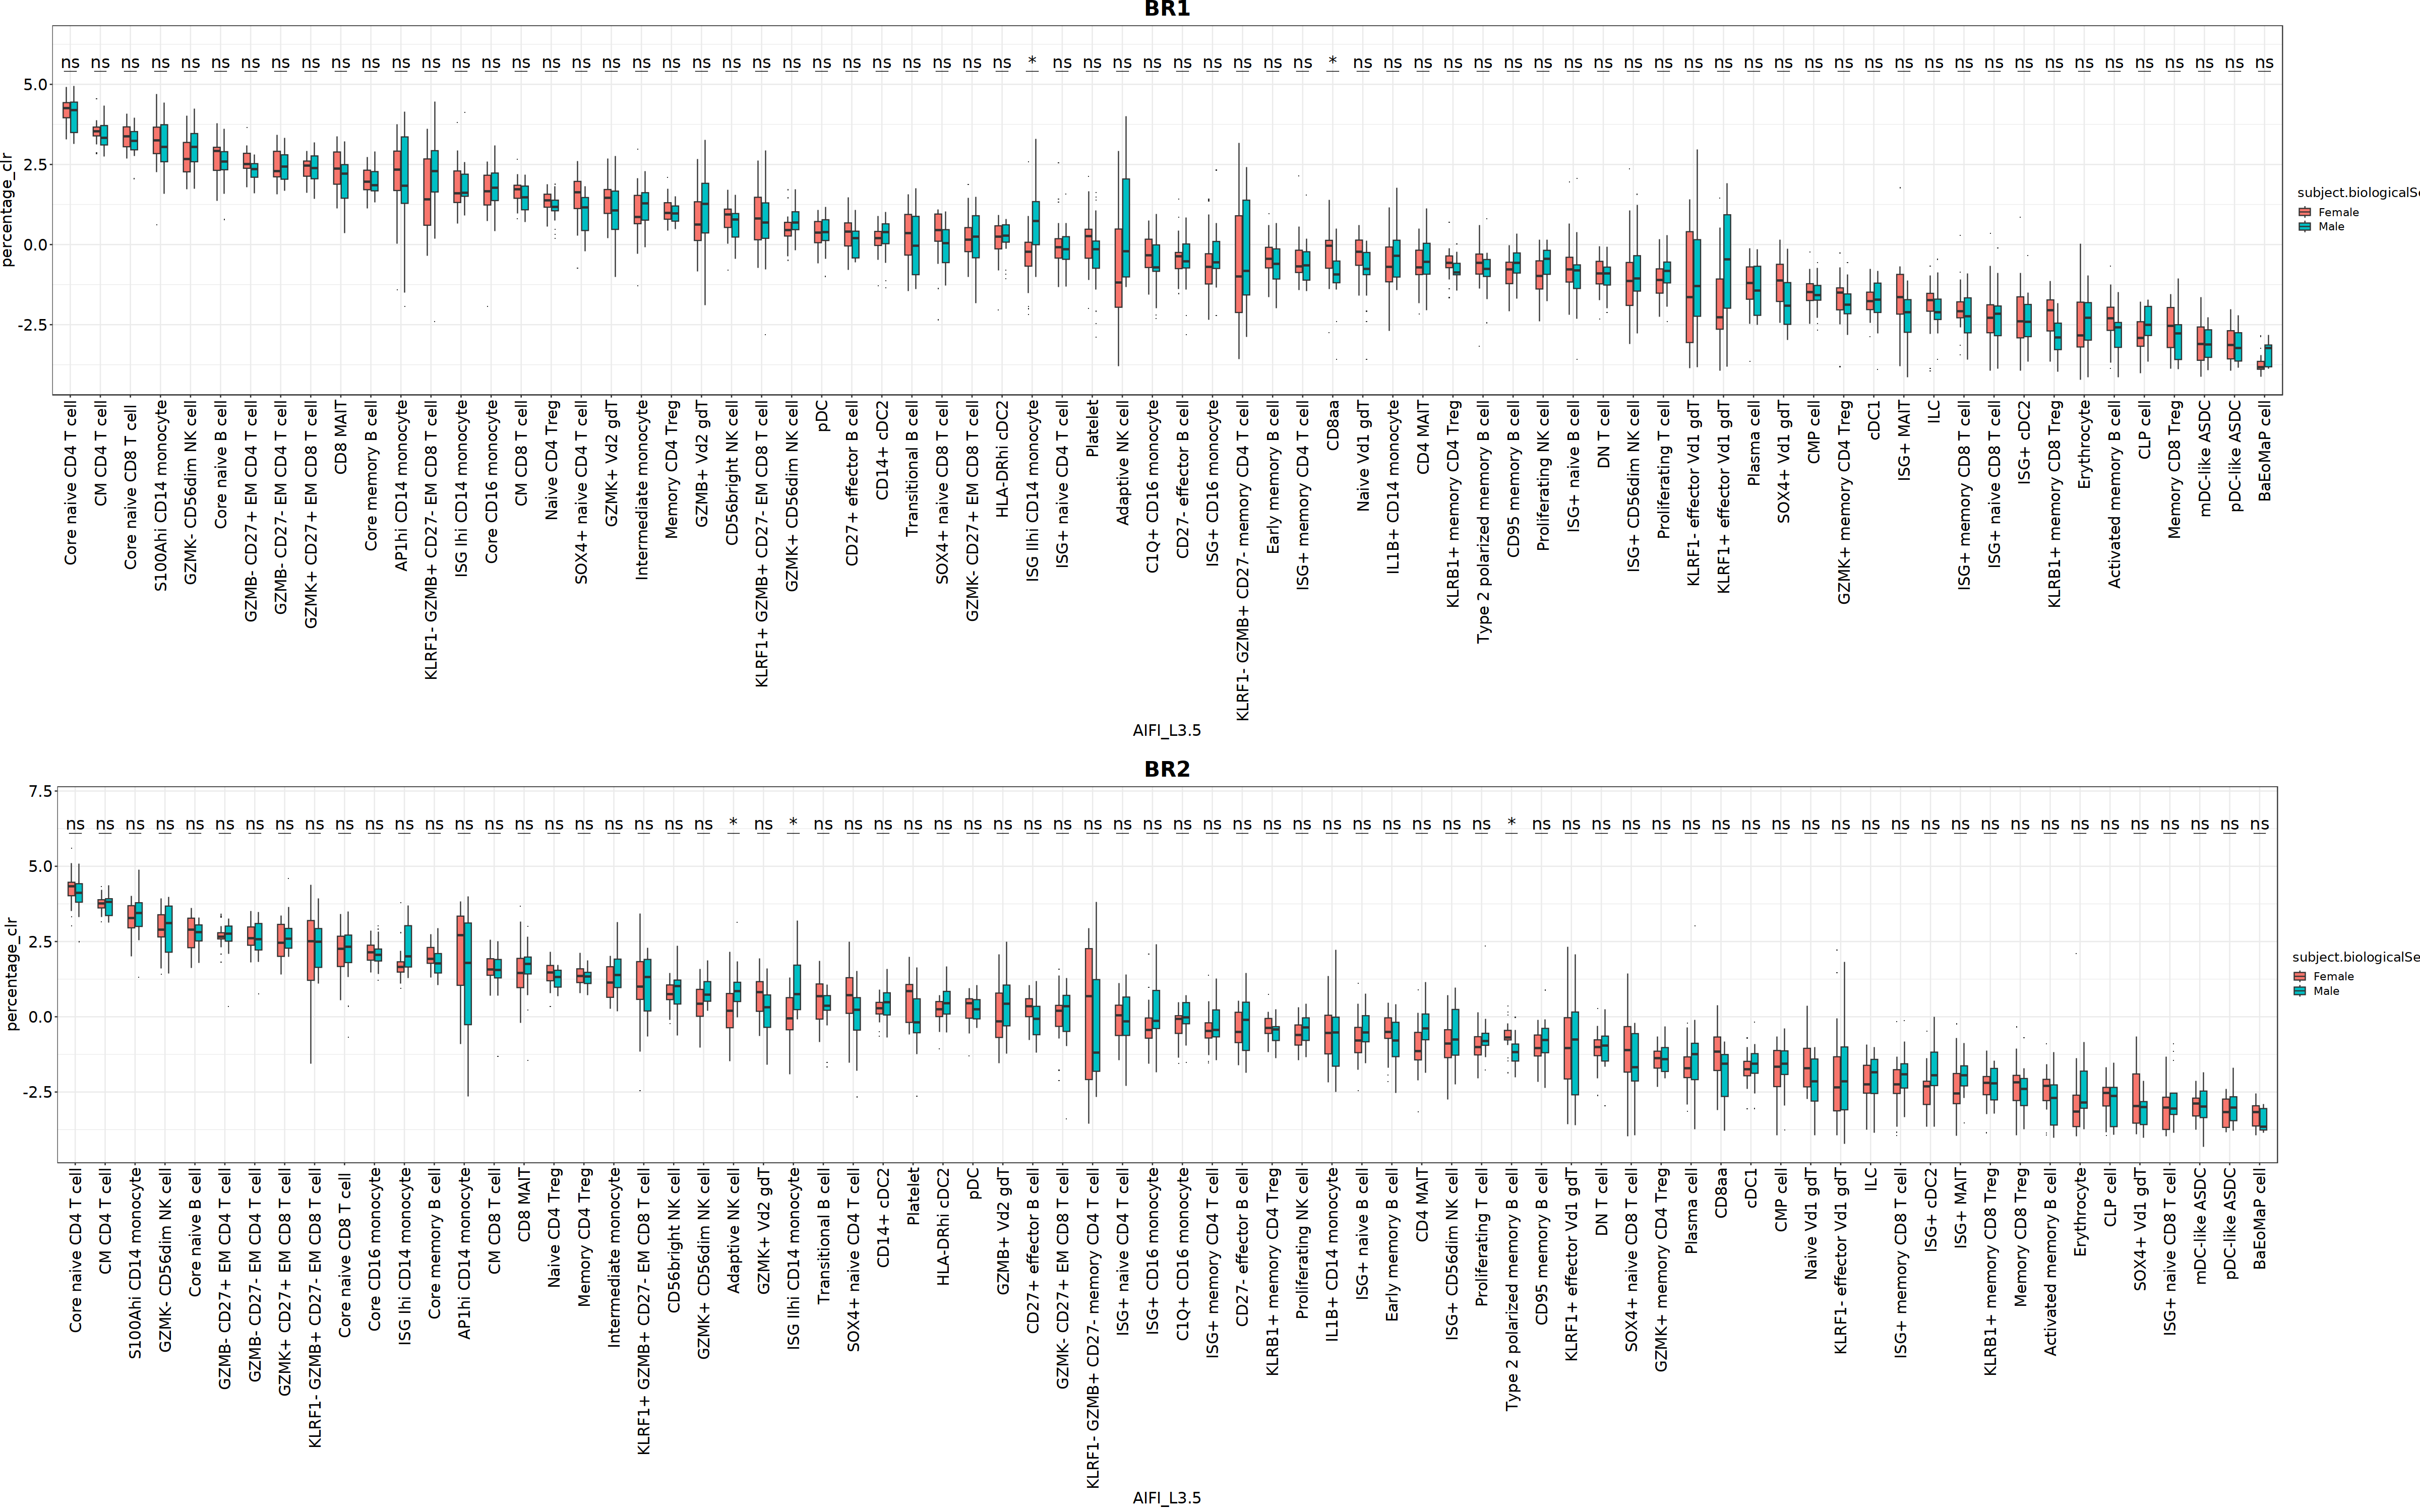

In [56]:
# CLR comparing Sex across BRI

####################. BR1 ####################
result_cohort <- result[result$cohort.cohortGuid == 'BR1', ]
#result_cohort <- result[result$CMV.IgG.Serology.Result.Interpretation == 'Positive', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3, cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p1 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black")) +
   ggtitle("BR1") + theme(plot.title = element_text(size = 25, hjust = 0.5, face = "bold"))

# Display the plot
#print(p1)


####################.BR2 ####################
result_cohort <- result[result$cohort.cohortGuid == 'BR2', ]

stat_test<- result_cohort %>%
  select(percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3, cohort.cohortGuid) %>%
  wilcox_test(percentage_clr ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()


# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p2 <- ggplot(result_cohort, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =7  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        axis.text.y = element_text(size = 18, color = "black"),
        axis.title.x = element_text(size = 18, color = "black"),
        axis.title.y = element_text(size = 18, color = "black"),
       legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        legend.title = element_text(size = 15, color = "black"))+
  ggtitle("BR2") + theme(plot.title = element_text(size = 25, hjust = 0.5, face = "bold"))

# Display the plot
#print(p2)

library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 25)
# Combine two plots vertically
#combined_plot <- plot_grid(p1, p2, labels = c("CMV_neg", "CMV_pos"), ncol =1, label_size = 20, vjust = 0)
#combined_plot <- plot_grid(p1, p2, ncol=1,  nrow = 2, rel_heights = c(1, 2))

stacked_plots <- plot_grid(p1 + theme(plot.margin = margin(b = 20)), p2, nrow = 2, rel_heights = c(1, 1))

# Print the stacked plots
stacked_plots


#combined_plot



# Comparsion within  AIFI Level 1 celltypes (Parent)

In [ ]:
Bcell_df <- myeloid_df %>% filter(AIFI_L1 == 'Monocyte')

In [121]:
unique(Bcell_df$AIFI_L2)

[1] "CD14 monocyte"         "CD16 monocyte"         "Intermediate monocyte"

In [122]:
unique(Bcell_df$AIFI_L3)

[1] "Core CD14 monocyte"    "Core CD16 monocyte"    "ISG+ CD16 monocyte"   
[4] "Intermediate monocyte" "C1Q+ CD16 monocyte"    "ISG+ CD14 monocyte"   
[7] "IL1B+ CD14 monocyte"

In [123]:
unique(Bcell_df$AIFI_L3.5)

[1] "S100Ahi CD14 monocyte"  "AP1hi CD14 monocyte"    "Core CD16 monocyte"    
[4] "ISG+ CD16 monocyte"     "Intermediate monocyte"  "C1Q+ CD16 monocyte"    
[7] "ISG Ihi CD14 monocyte"  "ISG IIhi CD14 monocyte" "IL1B+ CD14 monocyte"

In [109]:
## Percentage of total

result_Bcell <- Bcell_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(result_Bcell)
#sum(result_Bcell$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3.5'. You can override using the
`.groups` argument.


AIFI_L3.5  subject.subjectGuid count percentage percentage_clr
1 CD14+ cDC2 BR1001               60   23.52941   1.449500      
2 CD14+ cDC2 BR1002              108   29.67033   2.017918      
3 CD14+ cDC2 BR1003               67   28.75536   1.503536      
4 CD14+ cDC2 BR1004               76   33.48018   1.905379      
5 CD14+ cDC2 BR1005               87   33.33333   2.119713      
6 CD14+ cDC2 BR1006               65   25.39062   1.696290

In [110]:
result_Bcell<-left_join(result_Bcell,unique(myeloid_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [97]:
head(result_Bcell)

AIFI_L3      subject.subjectGuid count percentage percentage_clr
1 BaEoMaP cell BR1001              1      9.090909  -0.7324082    
2 BaEoMaP cell BR1002              2     11.764706  -0.8796858    
3 BaEoMaP cell BR1005              2      5.555556  -1.2458899    
4 BaEoMaP cell BR1006              1      6.666667  -1.1655025    
5 BaEoMaP cell BR1008              1     14.285714  -0.5364793    
6 BaEoMaP cell BR1009              1      5.263158  -1.4479351    
  cohort.cohortGuid subject.biologicalSex
1 BR1               Female               
2 BR1               Male                 
3 BR1               Female               
4 BR1               Male                 
5 BR1               Female               
6 BR1               Female               
  CMV.IgG.Serology.Result.Interpretation
1 Negative                              
2 Negative                              
3 Negative                              
4 Negative                              
5 Positive                              
6 Negative

In [104]:
result_Bcell %>% filter(subject.subjectGuid == "BR1001") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

# A tibble: 0 × 4
# ℹ 4 variables: AIFI_L3.5 <chr>, .y. <chr>, p.adj <dbl>, p.adj.signif <chr>
# A tibble: 0 × 4
# ℹ 4 variables: AIFI_L3.5 <chr>, .y. <chr>, p.adj <dbl>, p.adj.signif <chr>


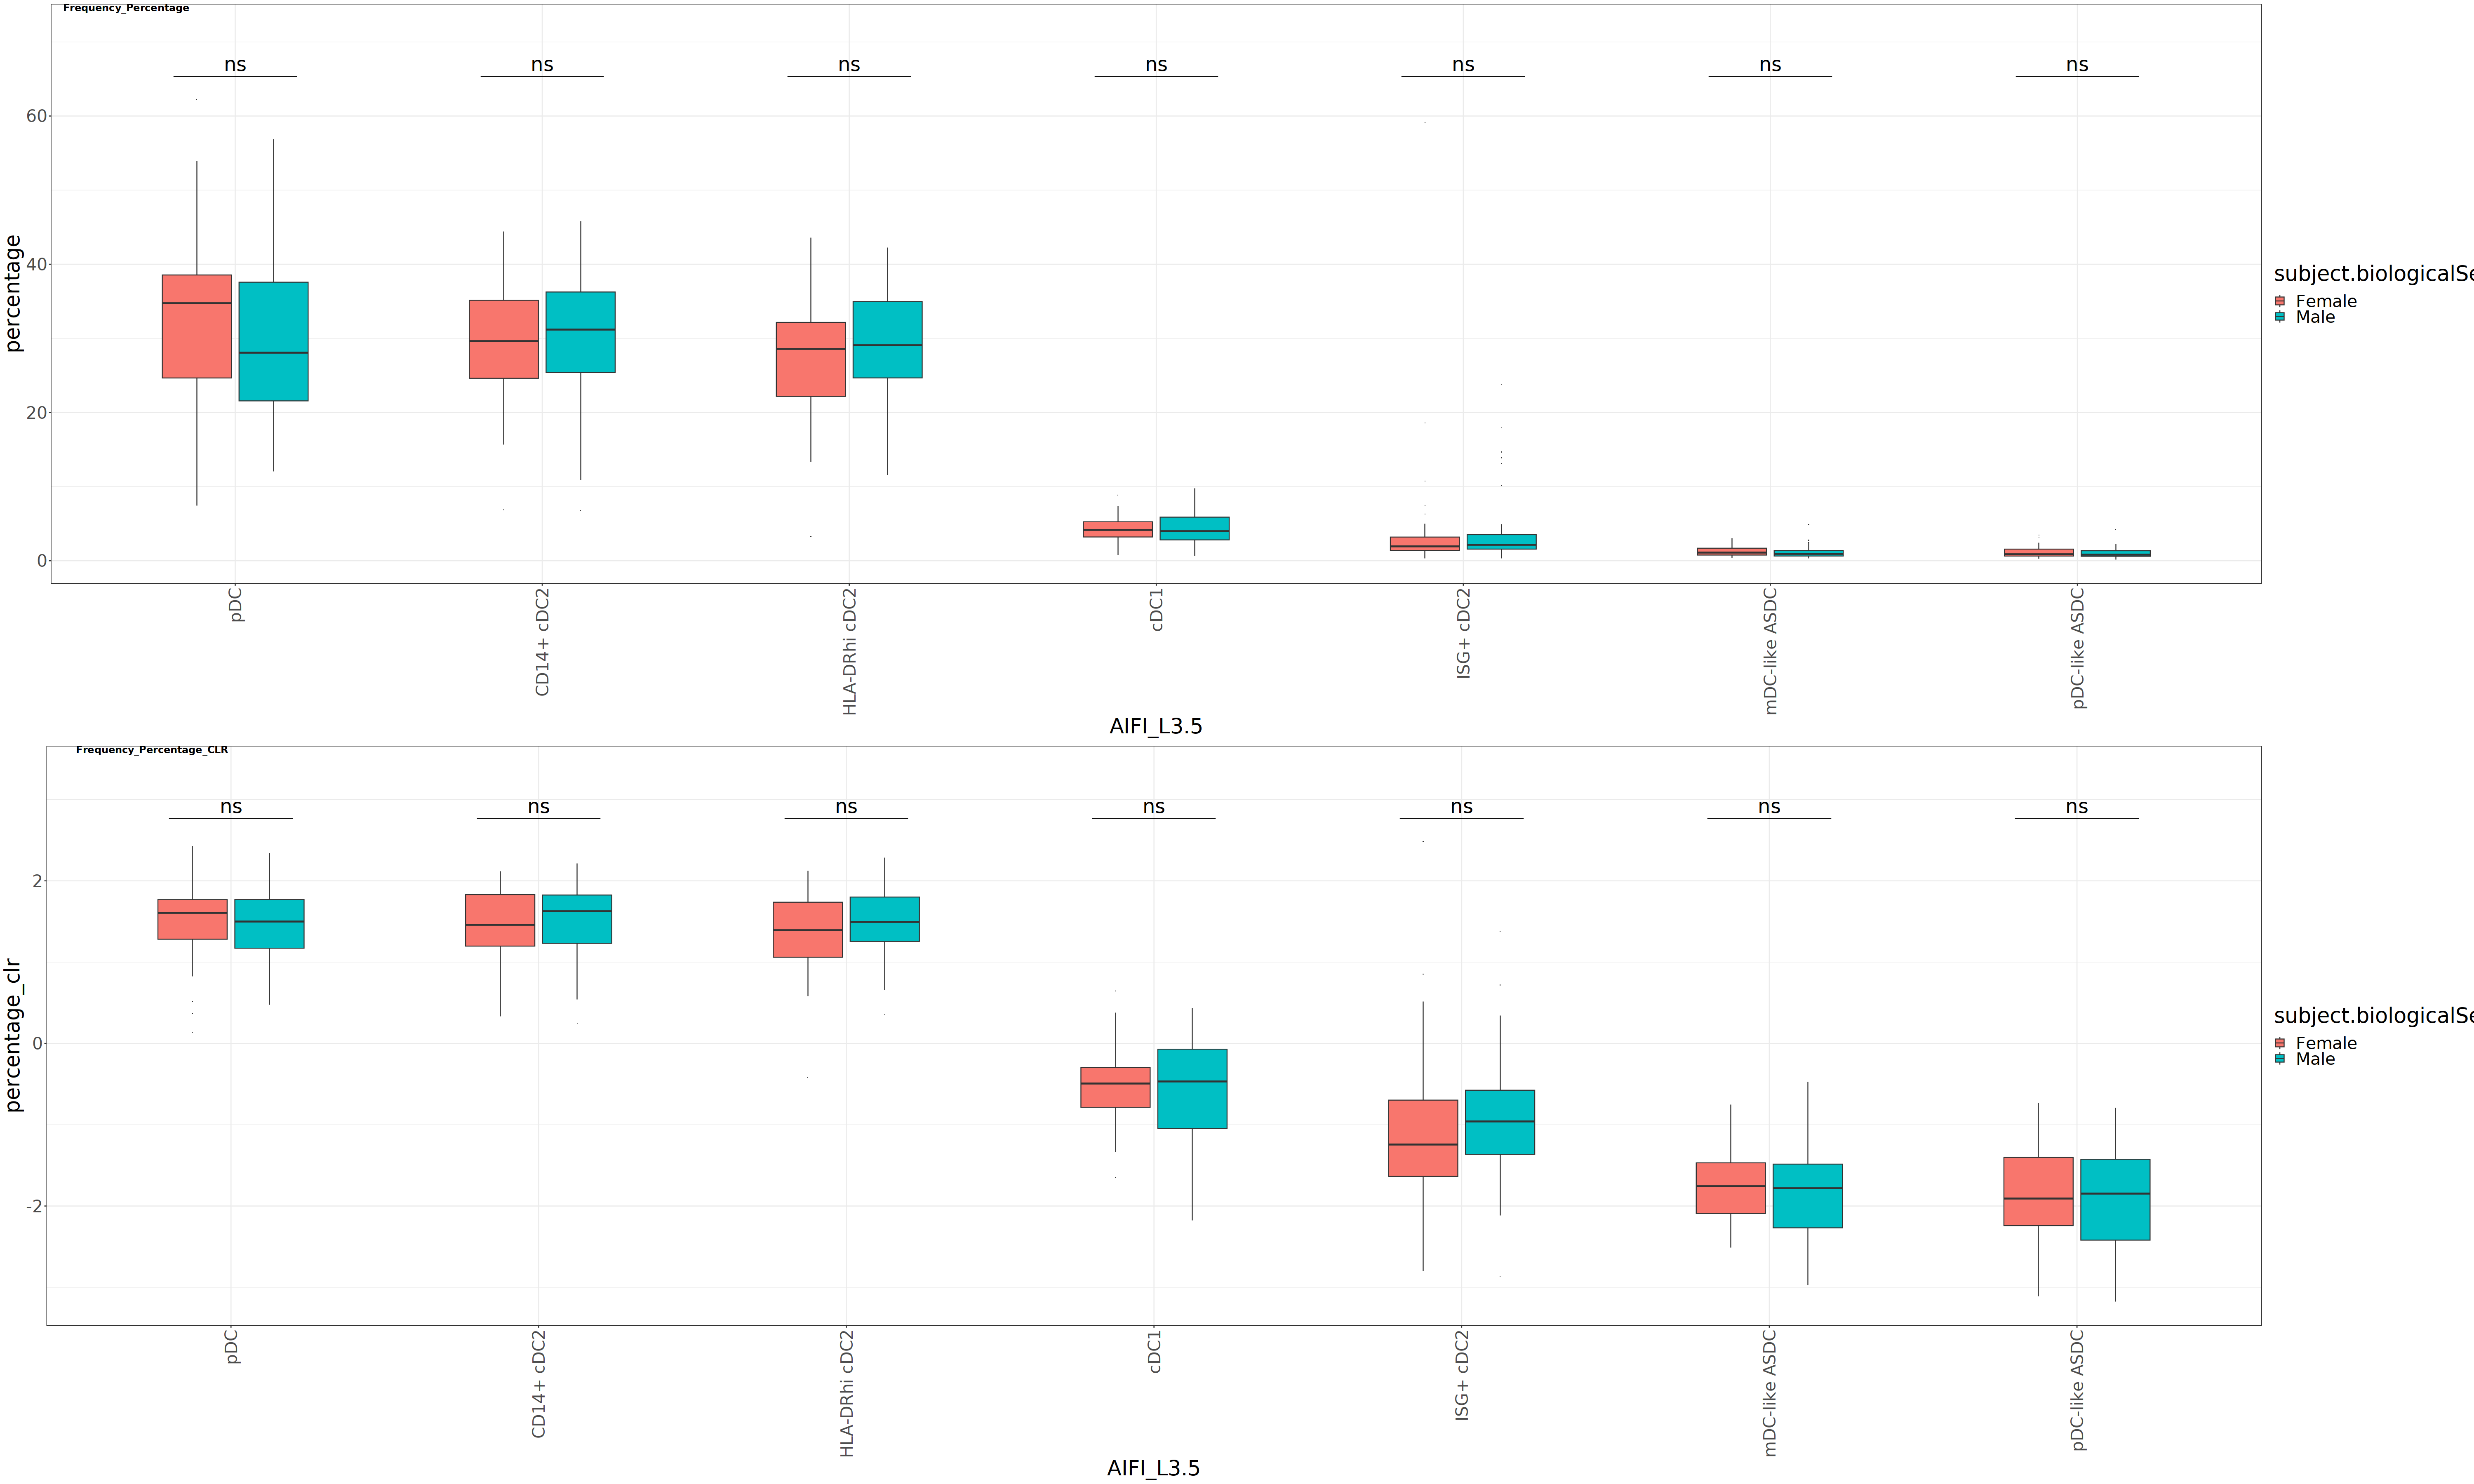

In [111]:

#Percentage stats
stat_test_1<- result_Bcell %>%
  select(percentage,percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>%
  wilcox_test(percentage ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()
#stat_test

significant_cell_types_1 <- stat_test_1 %>%
  filter(p.adj < 0.05) %>%
  select(AIFI_L3, .y., p.adj, p.adj.signif) %>%
  unique()

print(significant_cell_types_1)

#CLR stats
stat_test_2<- result_Bcell %>%
  select(percentage,percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, subject.biologicalSex) %>%
  unique(.) %>%
  group_by(AIFI_L3) %>%
  wilcox_test(percentage_clr ~ subject.biologicalSex) %>%
  adjust_pvalue(method = "BH") %>%
  add_significance()
#stat_test

significant_cell_types_2 <- stat_test_2 %>%
  filter(p.adj < 0.05) %>%
  select(AIFI_L3, .y., p.adj, p.adj.signif) %>%
  unique()

print(significant_cell_types_2)

# Create the plot
#options(repr.plot.width = 35, repr.plot.height = 12)
p4 <- ggplot(result_Bcell, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =10  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30),)
     # axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        #axis.text.y = element_text(size = 18, color = "black"),
        #axis.title.x = element_text(size = 18, color = "black"),
        #axis.title.y = element_text(size = 18, color = "black"),
       #legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        #legend.title = element_text(size = 15, color = "black"))

# Display the plot
#print(p4)


#Percentage CLR comparing Age WITHOUT CMV seperation
p5 <- ggplot(result_Bcell, aes(x = reorder(AIFI_L3, desc(percentage_clr)) , y = percentage_clr, fill = subject.biologicalSex)) +
  geom_boxplot(width = .5, outlier.shape = '.') +
  scale_x_discrete(name ="AIFI_L3", guide = guide_axis(angle = 90)) +
  theme_bw(base_size = 12) +
  geom_pwc(
    aes(group = subject.biologicalSex),
    tip.length = 0, p.adjust.method = "BH",
    method = "wilcox_test", label ="{p.adj.signif}", angle = 0, hide.ns = FALSE, label.size =10  # or "panel"
  ) +
  #facet_grid(cohort.cohortGuid ~ ., scales = "free_y", space = "free_y") +
   scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) +
  theme(text = element_text(size=30, color = "black"))
     # axis.text.x = element_text(size = 18, color = "black", angle = 90, hjust = 0.5, vjust = 0.5),
        #axis.text.y = element_text(size = 18, color = "black"),
        #axis.title.x = element_text(size = 18, color = "black"),
        #axis.title.y = element_text(size = 18, color = "black"),
       #legend.text = element_text(size = 13, color = "black"),  # Adjust the font size of legend text
        #legend.title = element_text(size = 15, color = "black"))


#print(p5)

#Combine Plot
library(cowplot)

options(repr.plot.width = 50, repr.plot.height = 30)
# Combine two plots vertically
combined_plot <- plot_grid(p4, p5, labels = c("Frequency_Percentage", "Frequency_Percentage_CLR"), ncol =1)

combined_plot
